***Spark:*** a distributed computed framework.<br>
Clusters itself consist of one or more nodes.<br>
Each node is a computer with node, ram and physical storage.<br>
Cluster manager: allocates resources and coordinates activity across the cluster<br>
Every application running on sparck cluster has a driver program, using spark API the driver communicates with the cluster manager, wich in turn distributes work on the nodes<br>
In each Node spark launches an executor process which persists for the duration of the application.<br>
Work is divided up into tasks, which are simply units of computation.<br>
The executors run task in multiple threads across the cores in a node.<br>

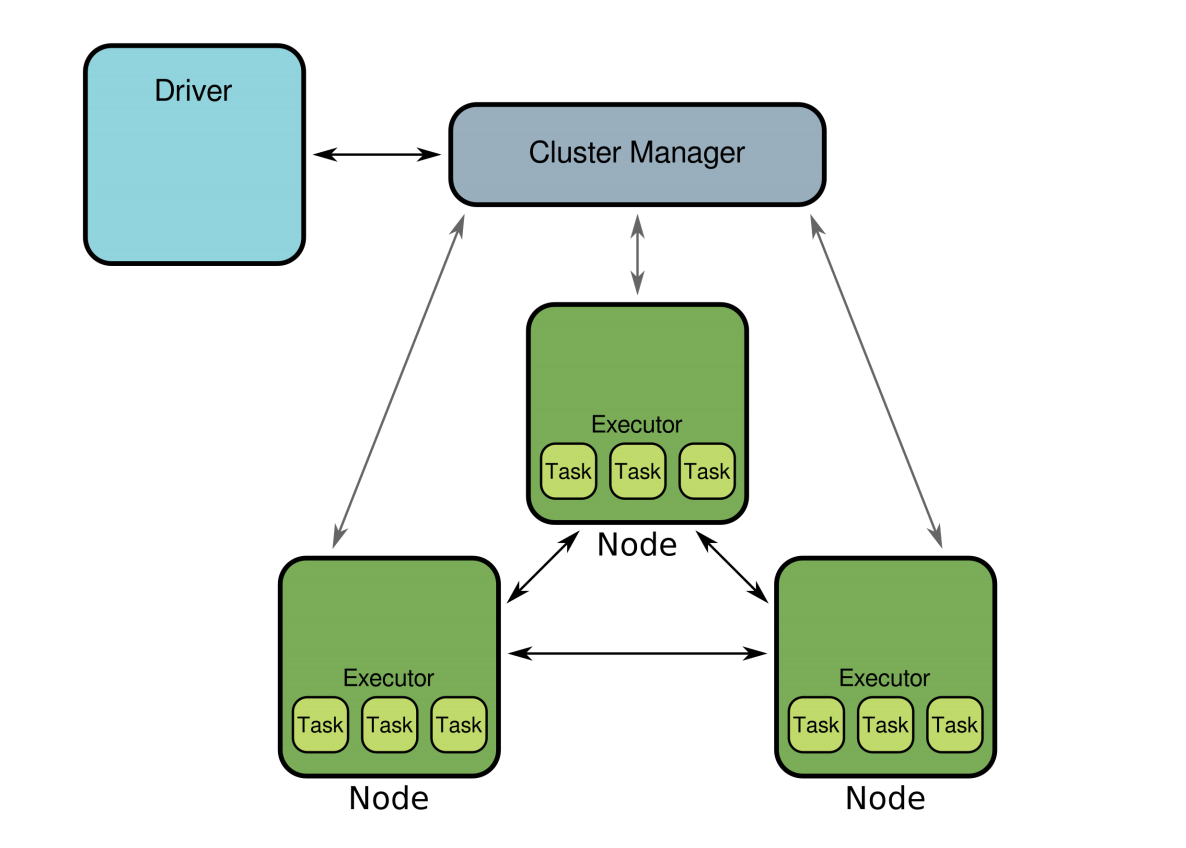

Java - low level compiled much code.
Scala, Python and R. High level with interactive REPL(Read, evaluate, print, loop). 
Less code. Higher level languague.



In [1]:
import pyspark


In [2]:
pyspark.__version__

'2.4.5'

Structured data -- pyspark.sql<br>
Streaming data -- pyspark.streaming<br>
Machine learning --pyspark.ml<br>


Remote cluster connection: spark://ip|DNS name: port. <br>
example: spark://13.59.151.161:7077 #7077 default port
Local clusters:<br>
local - only 1 core<br>
local[4] - 4 cores<br>
local[*] - all avalaible cores

In [3]:
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder \
                    .master('local[*]')\
                    .appName('spark_test')\
                    .getOrCreate()   ##create a new session or exist an existing object

In [5]:
#spark.stop() to stop the session once is done

***DATA READ***

Select methods: <br>
    count()<br>
    show()<br>
    printSchema()<br>
    
Select attributes:<br>
    dtypes<br>
    

***READ DATA FROM CSV:***<BR>
    spark.read.cvs('path',header=True);<br>
    Arguments:<br>
    header<br>
    sep<br>
    inferSchema<br>
    nullValue (place holder to indicate missing data so replace missing data with that value recommended 'NA')<br>
   
read_csv read the data by default like string so you can use inferSchema or manually assign datatypes.


In [12]:
flights = spark.read.csv("flights.csv",
                         sep=",",
                         header=True,
                        inferSchema=True,
                        nullValue='NA')
print("data contains {} rows".format(flights.count()))
flights.show(5)
flights.printSchema()

data contains 50000 rows
+---+---+---+-------+------+---+----+------+--------+-----+
|mon|dom|dow|carrier|flight|org|mile|depart|duration|delay|
+---+---+---+-------+------+---+----+------+--------+-----+
| 11| 20|  6|     US|    19|JFK|2153|  9.48|     351| null|
|  0| 22|  2|     UA|  1107|ORD| 316| 16.33|      82|   30|
|  2| 20|  4|     UA|   226|SFO| 337|  6.17|      82|   -8|
|  9| 13|  1|     AA|   419|ORD|1236| 10.33|     195|   -5|
|  4|  2|  5|     AA|   325|ORD| 258|  8.92|      65| null|
+---+---+---+-------+------+---+----+------+--------+-----+
only showing top 5 rows

root
 |-- mon: integer (nullable = true)
 |-- dom: integer (nullable = true)
 |-- dow: integer (nullable = true)
 |-- carrier: string (nullable = true)
 |-- flight: integer (nullable = true)
 |-- org: string (nullable = true)
 |-- mile: integer (nullable = true)
 |-- depart: double (nullable = true)
 |-- duration: integer (nullable = true)
 |-- delay: integer (nullable = true)



In [16]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

# Specify column names and types
schema = StructType([
    StructField("id", IntegerType()),
    StructField("text", StringType()),
    StructField("label", IntegerType())
])

# Load data from a delimited file
sms = spark.read.csv("sms.csv", sep=";", header=False, schema=schema)

# Print schema of DataFrame
sms.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)



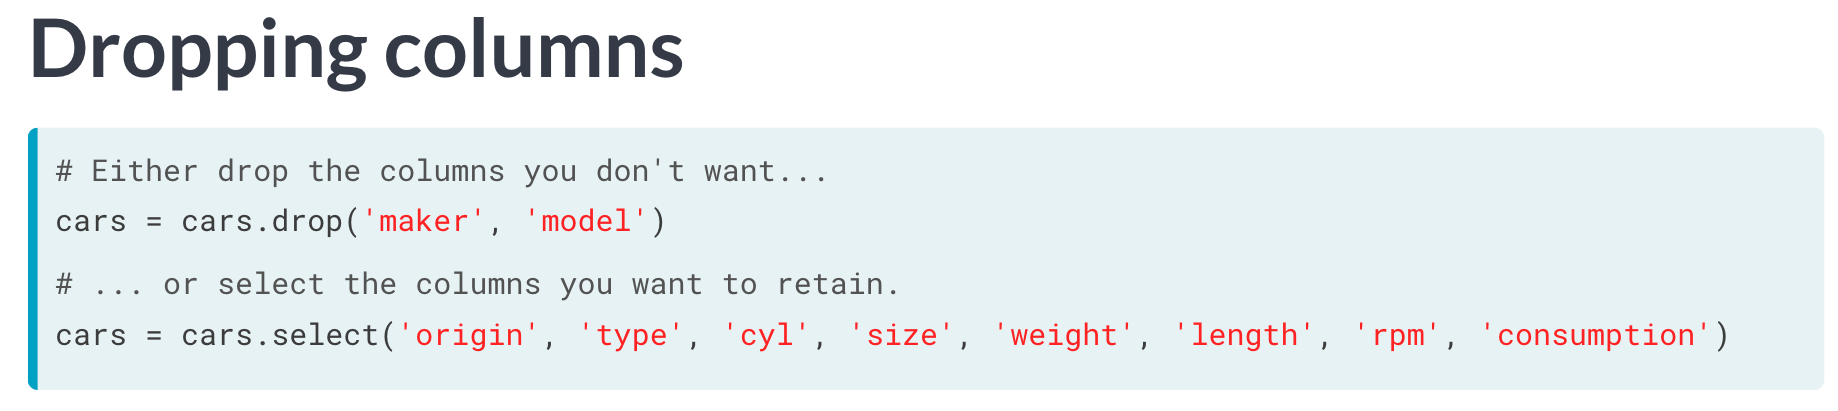

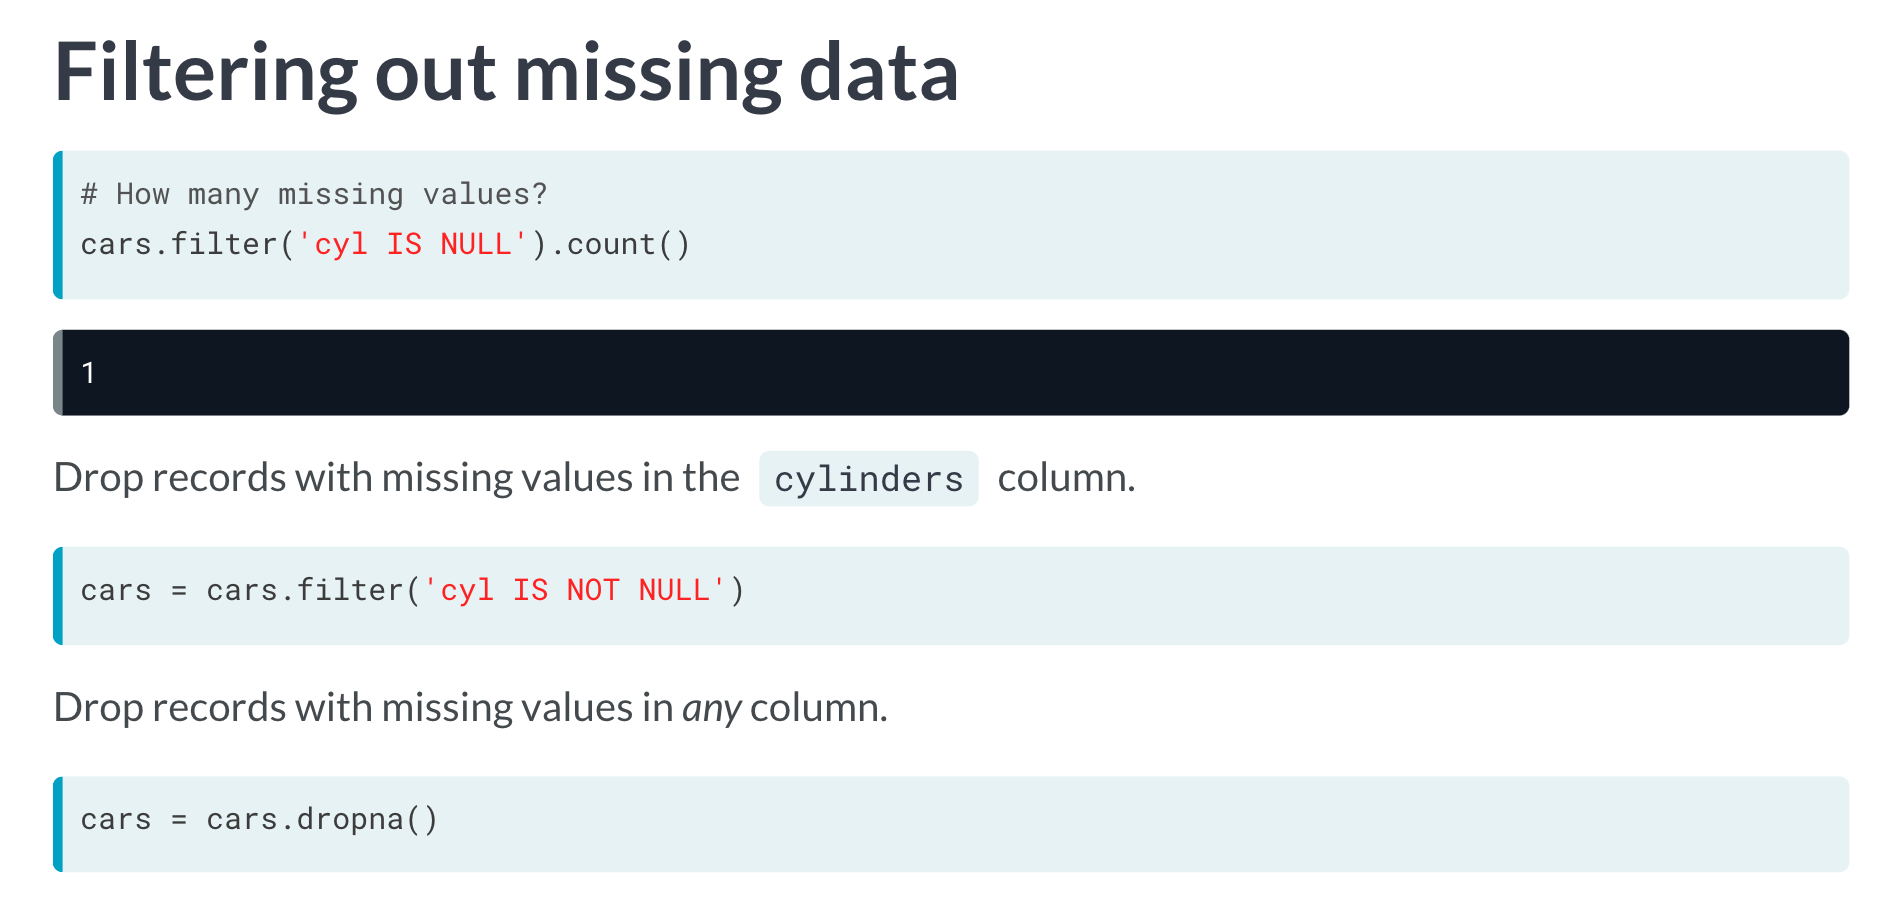

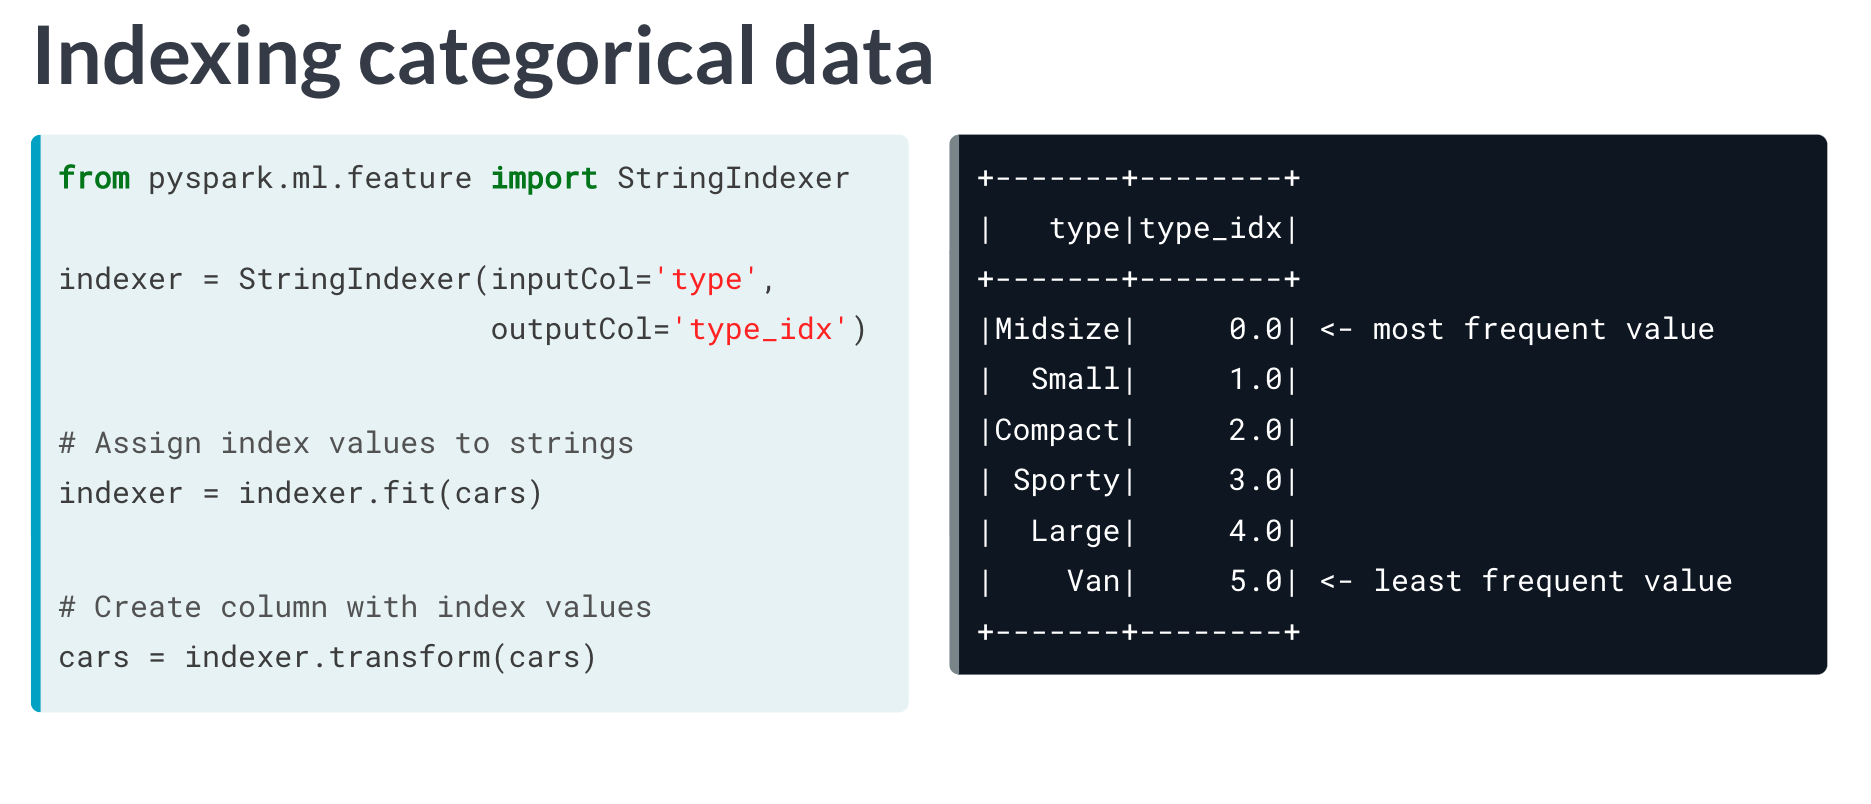

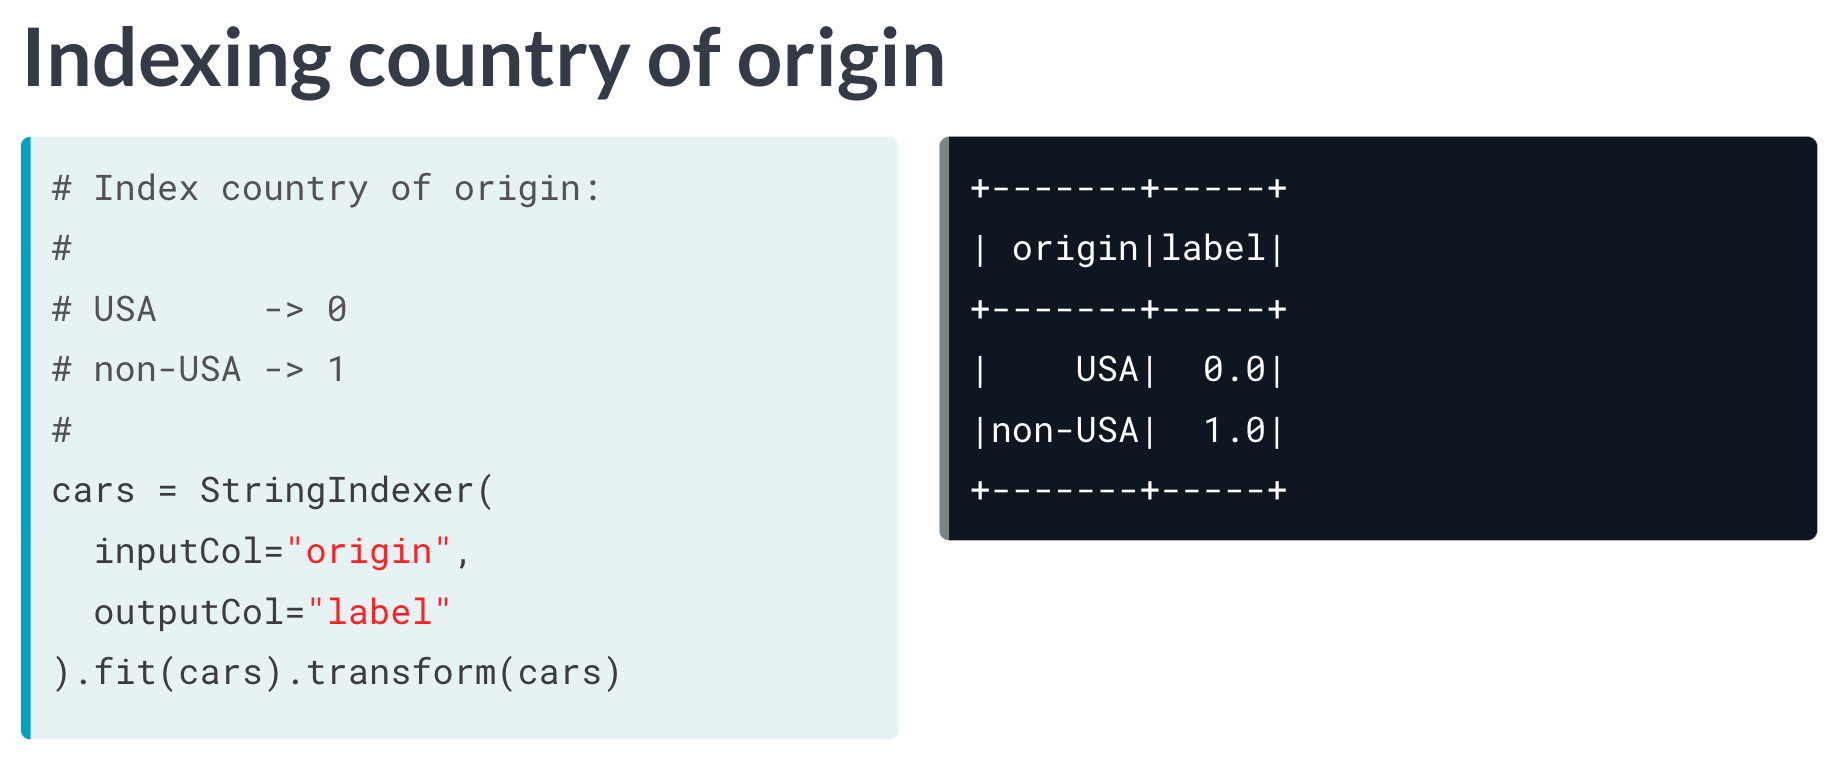

**Spark operates in a singles vector of predictors**

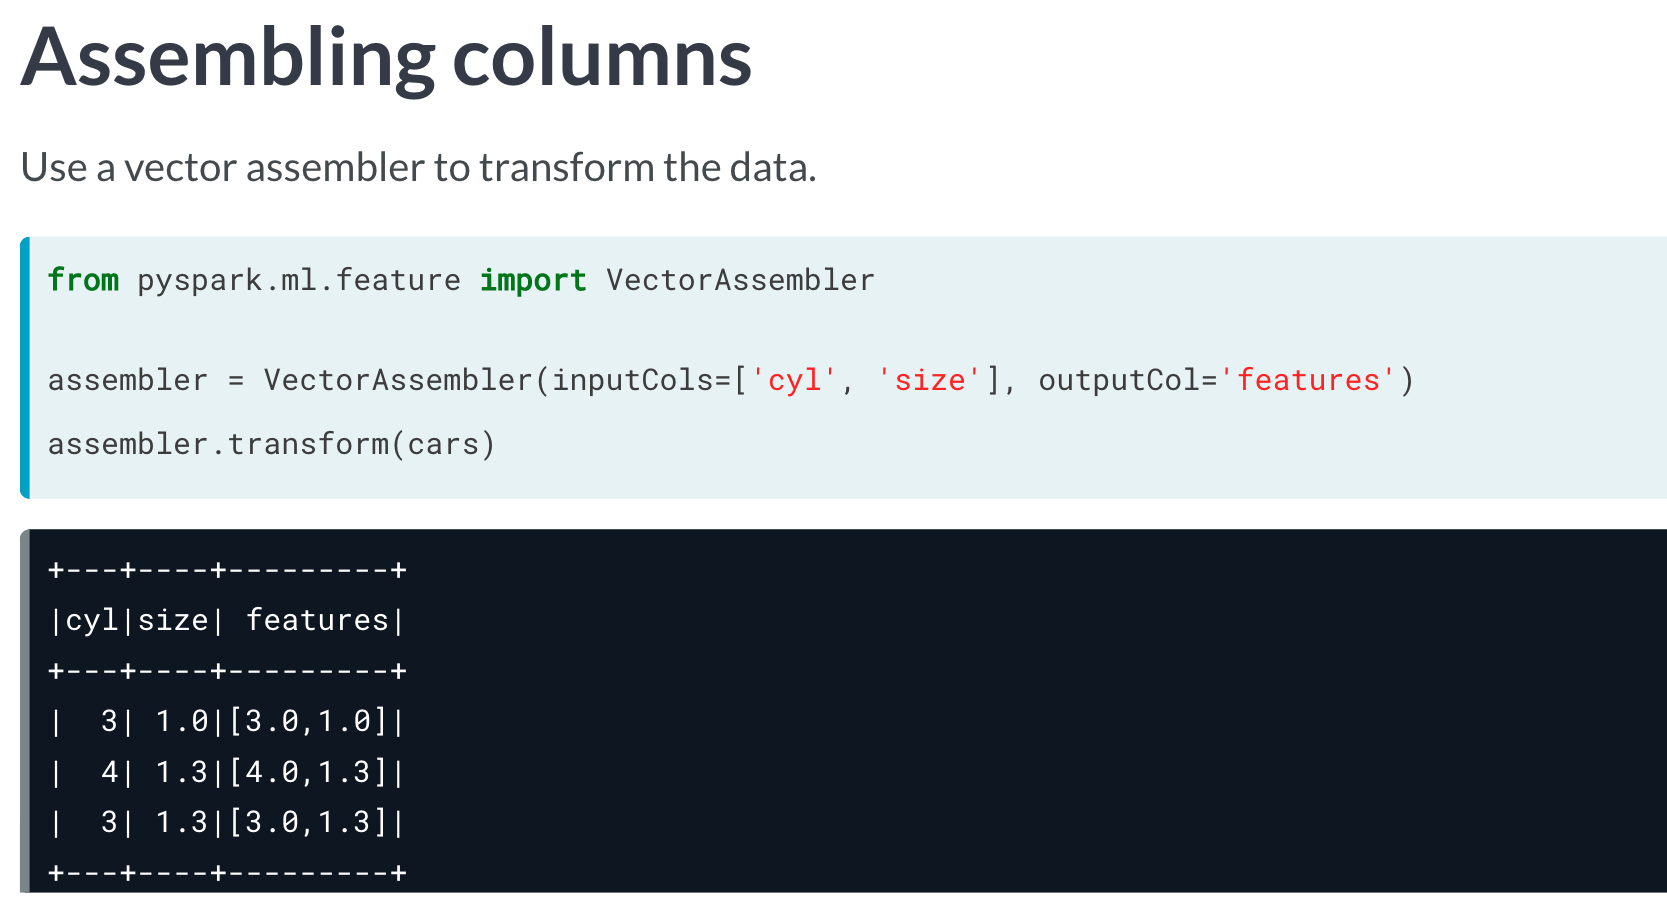

In [17]:
# Remove the 'flight' column
flights_drop_column = flights.drop("flight")

# Number of records with missing 'delay' values
flights_drop_column.filter('delay IS NULL').count()

# Remove records with missing 'delay' values
flights_valid_delay = flights_drop_column.filter('delay IS NOT NULL')

# Remove records with missing values in any column and get the number of remaining rows
flights_none_missing = flights_valid_delay.dropna()
print(flights_none_missing.count())

47022


In [21]:
# Import the required function
from pyspark.sql.functions import round

# Convert 'mile' to 'km' and drop 'mile' column
flights_km = flights.withColumn('km', round(flights.mile * 1.60934, 0)) \
                    .drop('mile')

# Create 'label' column indicating whether flight delayed (1) or not (0)
flights_km = flights_km.withColumn('label', (flights_km.delay>=15).cast('integer'))

# Check first five records
flights_km.show(5)

+---+---+---+-------+------+---+------+--------+-----+------+-----+
|mon|dom|dow|carrier|flight|org|depart|duration|delay|    km|label|
+---+---+---+-------+------+---+------+--------+-----+------+-----+
| 11| 20|  6|     US|    19|JFK|  9.48|     351| null|3465.0| null|
|  0| 22|  2|     UA|  1107|ORD| 16.33|      82|   30| 509.0|    1|
|  2| 20|  4|     UA|   226|SFO|  6.17|      82|   -8| 542.0|    0|
|  9| 13|  1|     AA|   419|ORD| 10.33|     195|   -5|1989.0|    0|
|  4|  2|  5|     AA|   325|ORD|  8.92|      65| null| 415.0| null|
+---+---+---+-------+------+---+------+--------+-----+------+-----+
only showing top 5 rows



In [22]:
from pyspark.ml.feature import StringIndexer

# Create an indexer
indexer = StringIndexer(inputCol='carrier', outputCol='carrier_idx')

# Indexer identifies categories in the data
indexer_model = indexer.fit(flights)

# Indexer creates a new column with numeric index values
flights_indexed = indexer_model.transform(flights)

# Repeat the process for the other categorical feature
flights_indexed = StringIndexer(inputCol='org', outputCol='org_idx').fit(flights_indexed).transform(flights_indexed)

In [43]:
# Import the necessary class
from pyspark.ml.feature import VectorAssembler

# Create an assembler object
assembler = VectorAssembler(inputCols=[
    'mon','dom','dow','depart','duration'
], outputCol='features')

# Consolidate predictor columns
flights_assembled = assembler.transform(flights)

flights_assembled = flights_assembled.withColumn('label', (flights_assembled.delay>=15).cast('integer'))


flights_assembled = flights_assembled.dropna()
# Check the resulting column
flights_assembled.select('features', 'delay','label').show(5, truncate=False)

+--------------------------+-----+-----+
|features                  |delay|label|
+--------------------------+-----+-----+
|[0.0,22.0,2.0,16.33,82.0] |30   |1    |
|[2.0,20.0,4.0,6.17,82.0]  |-8   |0    |
|[9.0,13.0,1.0,10.33,195.0]|-5   |0    |
|[5.0,2.0,1.0,7.98,102.0]  |2    |0    |
|[7.0,2.0,6.0,10.83,135.0] |54   |1    |
+--------------------------+-----+-----+
only showing top 5 rows



***Decision Tree***

In [44]:
# Split into training and testing sets in a 80:20 ratio
flights_train, flights_test = flights_assembled.randomSplit([0.8,0.2],seed=17)

# Check that training set has around 80% of records
training_ratio = flights_train.count() / flights.count()
print(training_ratio)

0.75054


In [45]:
flights_train.show()

+---+---+---+-------+------+---+----+------+--------+-----+--------------------+-----+
|mon|dom|dow|carrier|flight|org|mile|depart|duration|delay|            features|label|
+---+---+---+-------+------+---+----+------+--------+-----+--------------------+-----+
|  0|  1|  2|     AA|     3|JFK|2475|  12.0|     370|   11|[0.0,1.0,2.0,12.0...|    0|
|  0|  1|  2|     AA|    59|JFK|2586|   7.0|     385|  -16|[0.0,1.0,2.0,7.0,...|    0|
|  0|  1|  2|     AA|    73|ORD|4243|  9.08|     560|   39|[0.0,1.0,2.0,9.08...|    1|
|  0|  1|  2|     AA|   150|SFO|2704| 23.42|     325|   22|[0.0,1.0,2.0,23.4...|    1|
|  0|  1|  2|     AA|   181|JFK|2475|  17.0|     379|  -10|[0.0,1.0,2.0,17.0...|    0|
|  0|  1|  2|     AA|   254|OGG|2486| 15.33|     310|  173|[0.0,1.0,2.0,15.3...|    1|
|  0|  1|  2|     AA|   317|LGA| 733|  9.92|     170|   -9|[0.0,1.0,2.0,9.92...|    0|
|  0|  1|  2|     AA|   335|LGA| 733| 14.58|     165|   -4|[0.0,1.0,2.0,14.5...|    0|
|  0|  1|  2|     AA|   336|ORD| 733| 21.58

In [46]:
# Import the Decision Tree Classifier class
from pyspark.ml.classification import DecisionTreeClassifier
# Create a classifier object and fit to the training data
tree = DecisionTreeClassifier()
tree_model = tree.fit(flights_train)
# Create predictions for the testing data and take a look at the predictions
prediction = tree_model.transform(flights_test)
prediction.select('label', 'prediction', 'probability').show(5, False)

+-----+----------+---------------------------------------+
|label|prediction|probability                            |
+-----+----------+---------------------------------------+
|1    |1.0       |[0.337731156050611,0.662268843949389]  |
|1    |1.0       |[0.4200576738224928,0.5799423261775072]|
|1    |1.0       |[0.337731156050611,0.662268843949389]  |
|1    |1.0       |[0.337731156050611,0.662268843949389]  |
|0    |1.0       |[0.4200576738224928,0.5799423261775072]|
+-----+----------+---------------------------------------+
only showing top 5 rows



In [47]:
# Create a confusion matrix
prediction.groupBy("label", 'prediction').count().show()

# Calculate the elements of the confusion matrix
TN = prediction.filter('prediction = 0 AND label = prediction').count()
TP = prediction.filter('prediction = 1 AND label = prediction').count()
FN = prediction.filter('prediction = 0 AND label = 1').count()
FP = prediction.filter('prediction = 1 AND label = 0').count()

# Accuracy measures the proportion of correct predictions
accuracy = (TN+TP)/(TN+TP+FN+FP)
print(accuracy)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 1527|
|    0|       0.0| 2662|
|    1|       1.0| 3338|
|    0|       1.0| 1968|
+-----+----------+-----+

0.631911532385466


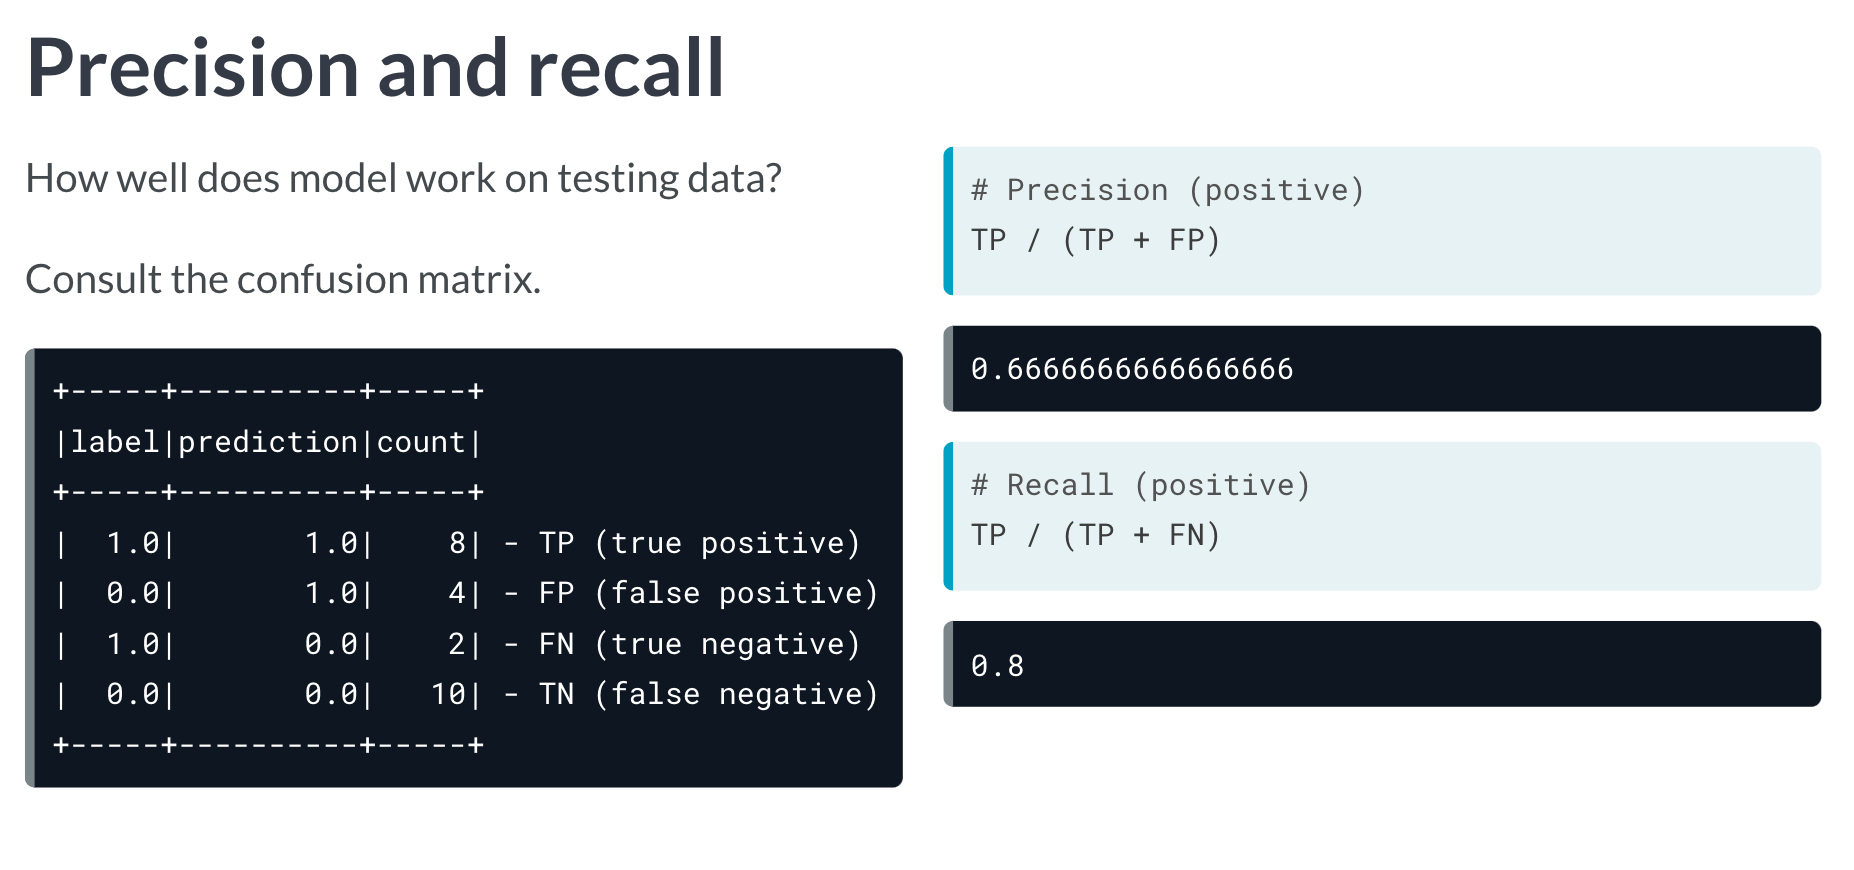

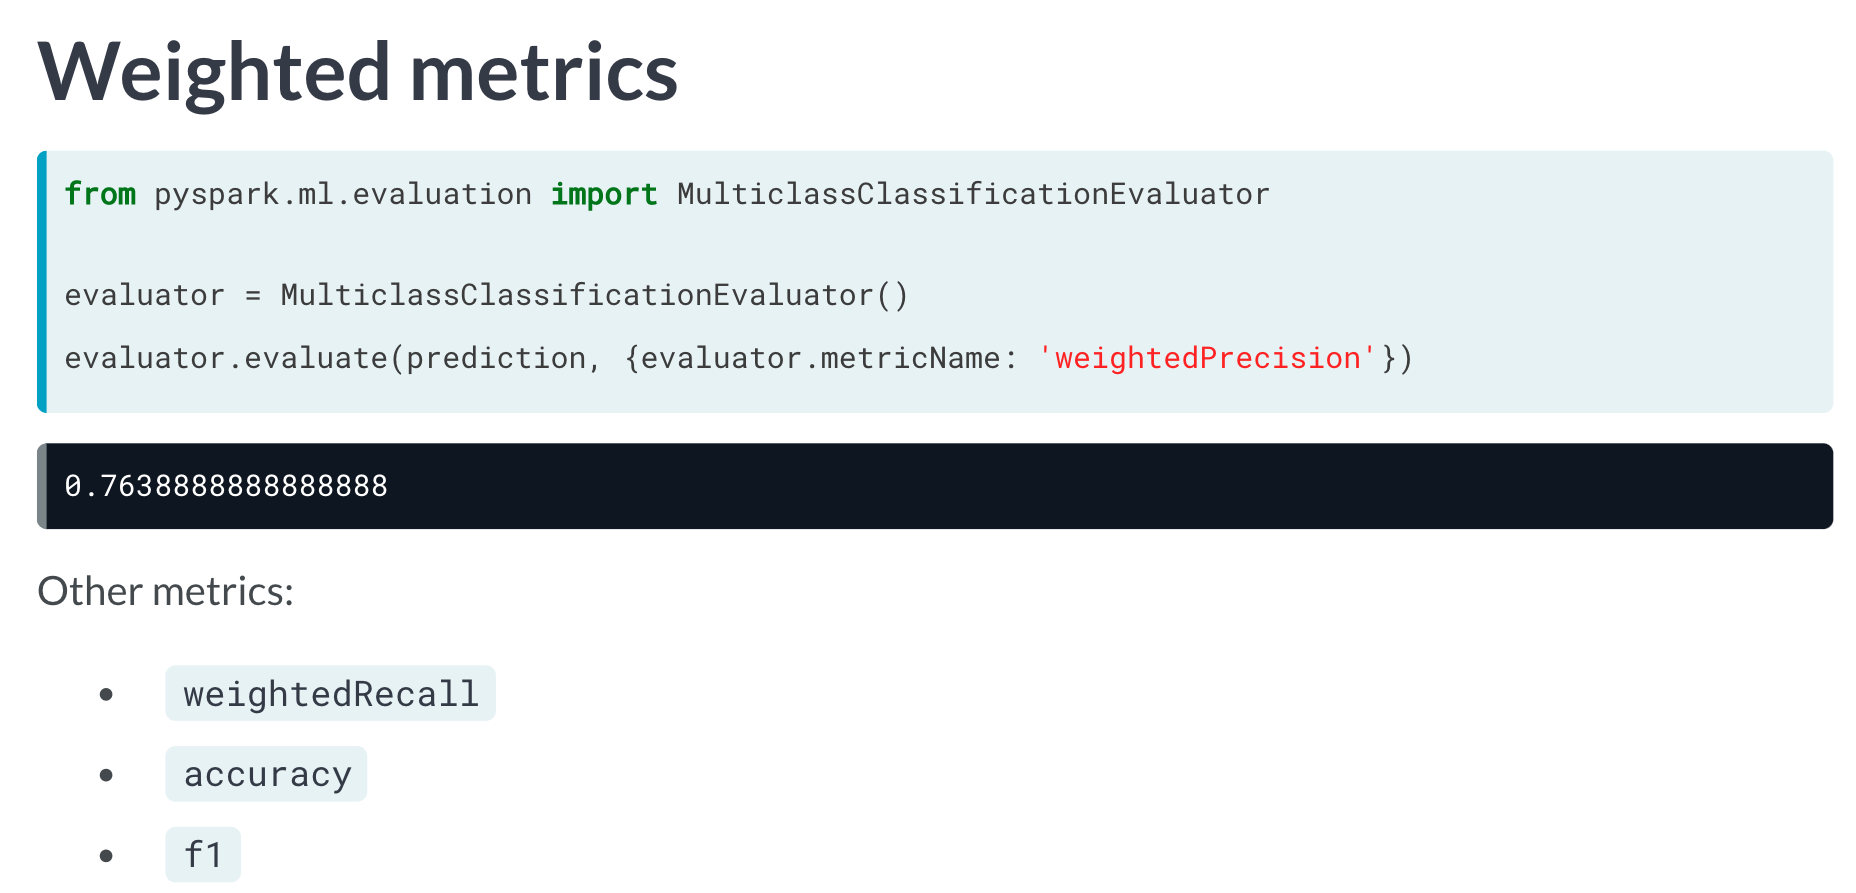

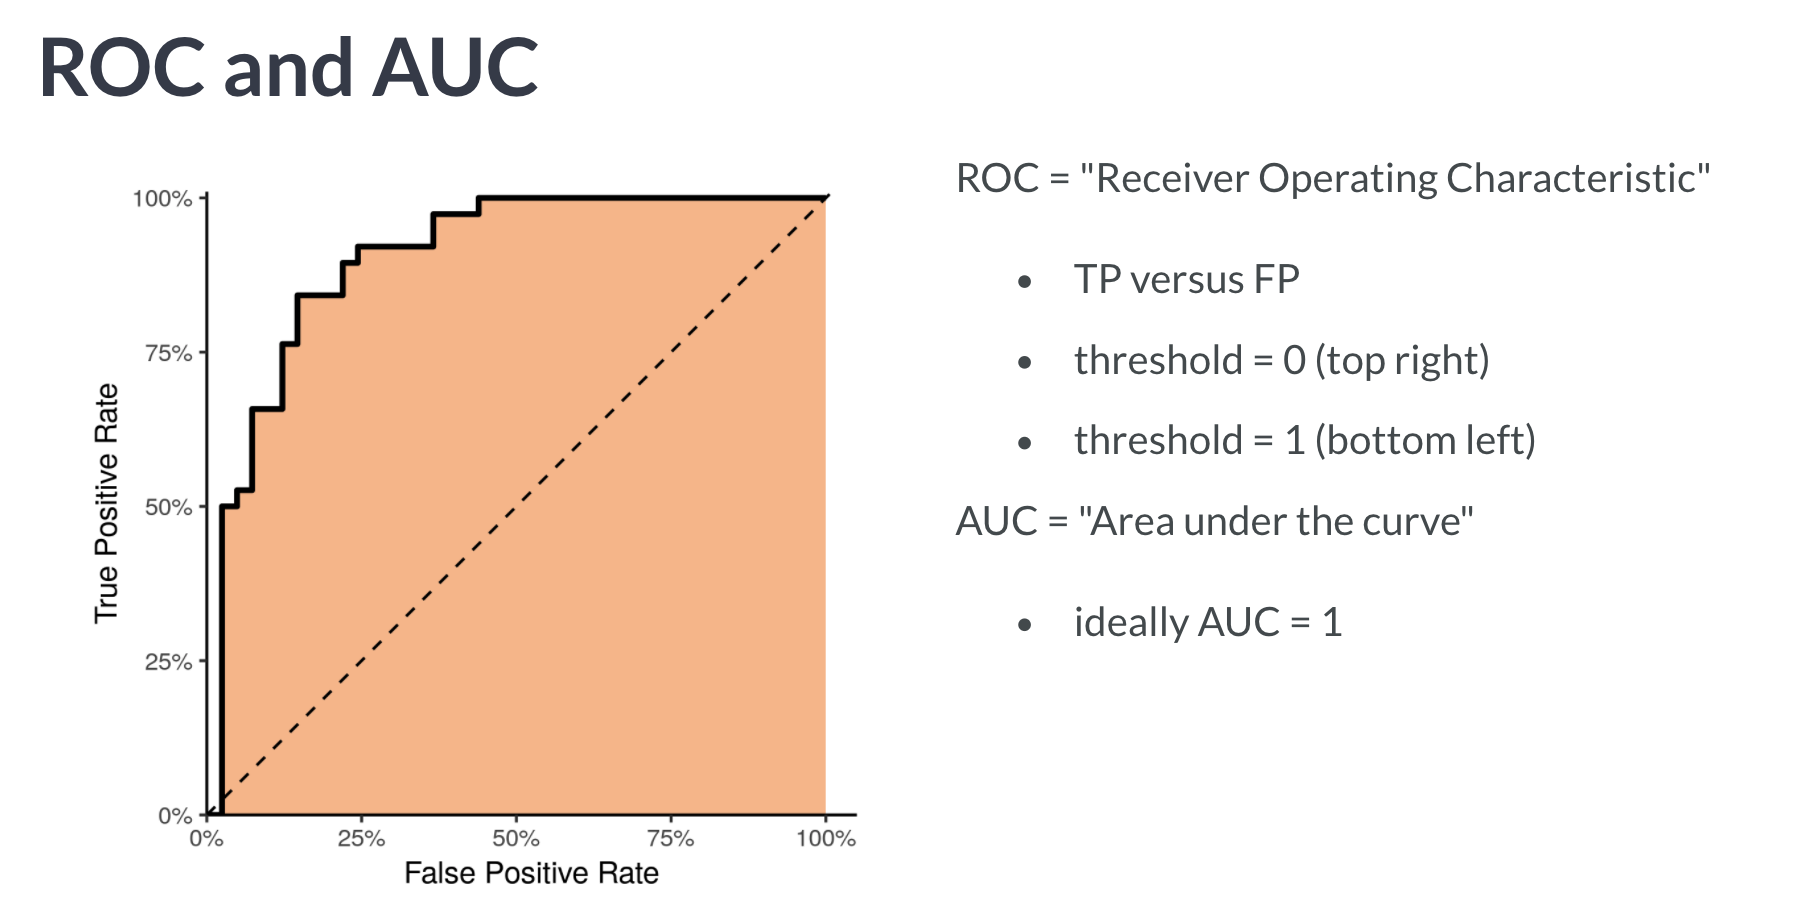

In [48]:
# Import the logistic regression class
from pyspark.ml.classification import LogisticRegression

# Create a classifier object and train on training data
logistic = LogisticRegression().fit(flights_train)

# Create predictions for the testing data and show confusion matrix
prediction = logistic.transform(flights_test)
prediction.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 1823|
|    0|       0.0| 2597|
|    1|       1.0| 3042|
|    0|       1.0| 2033|
+-----+----------+-----+



In [52]:
#TP + TN / TP+TN+FP+FN
TN = prediction.filter('prediction = 0 AND label = prediction').count()
TP = prediction.filter('prediction = 1 AND label = prediction').count()
FN = prediction.filter('prediction = 0 AND label = 1').count()
FP = prediction.filter('prediction = 1 AND label = 0').count()
accuracy = (TN+TP)/(TN+TP+FN+FP)
print(accuracy)


0.5938915218536072


In [53]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Calculate precision and recall
precision = TP/(TP+FP)
recall = TP/(TP+FN)
print('precision = {:.2f}\nrecall    = {:.2f}'.format(precision, recall))

# Find weighted precision
multi_evaluator = MulticlassClassificationEvaluator()
weighted_precision = multi_evaluator.evaluate(prediction, {multi_evaluator.metricName: "weightedPrecision"})

# Find AUC
binary_evaluator = BinaryClassificationEvaluator()
auc = binary_evaluator.evaluate(prediction, {binary_evaluator.metricName: "areaUnderROC"})

precision = 0.60
recall    = 0.63


***TEXT DATA MANIPULATION IN SPARK***

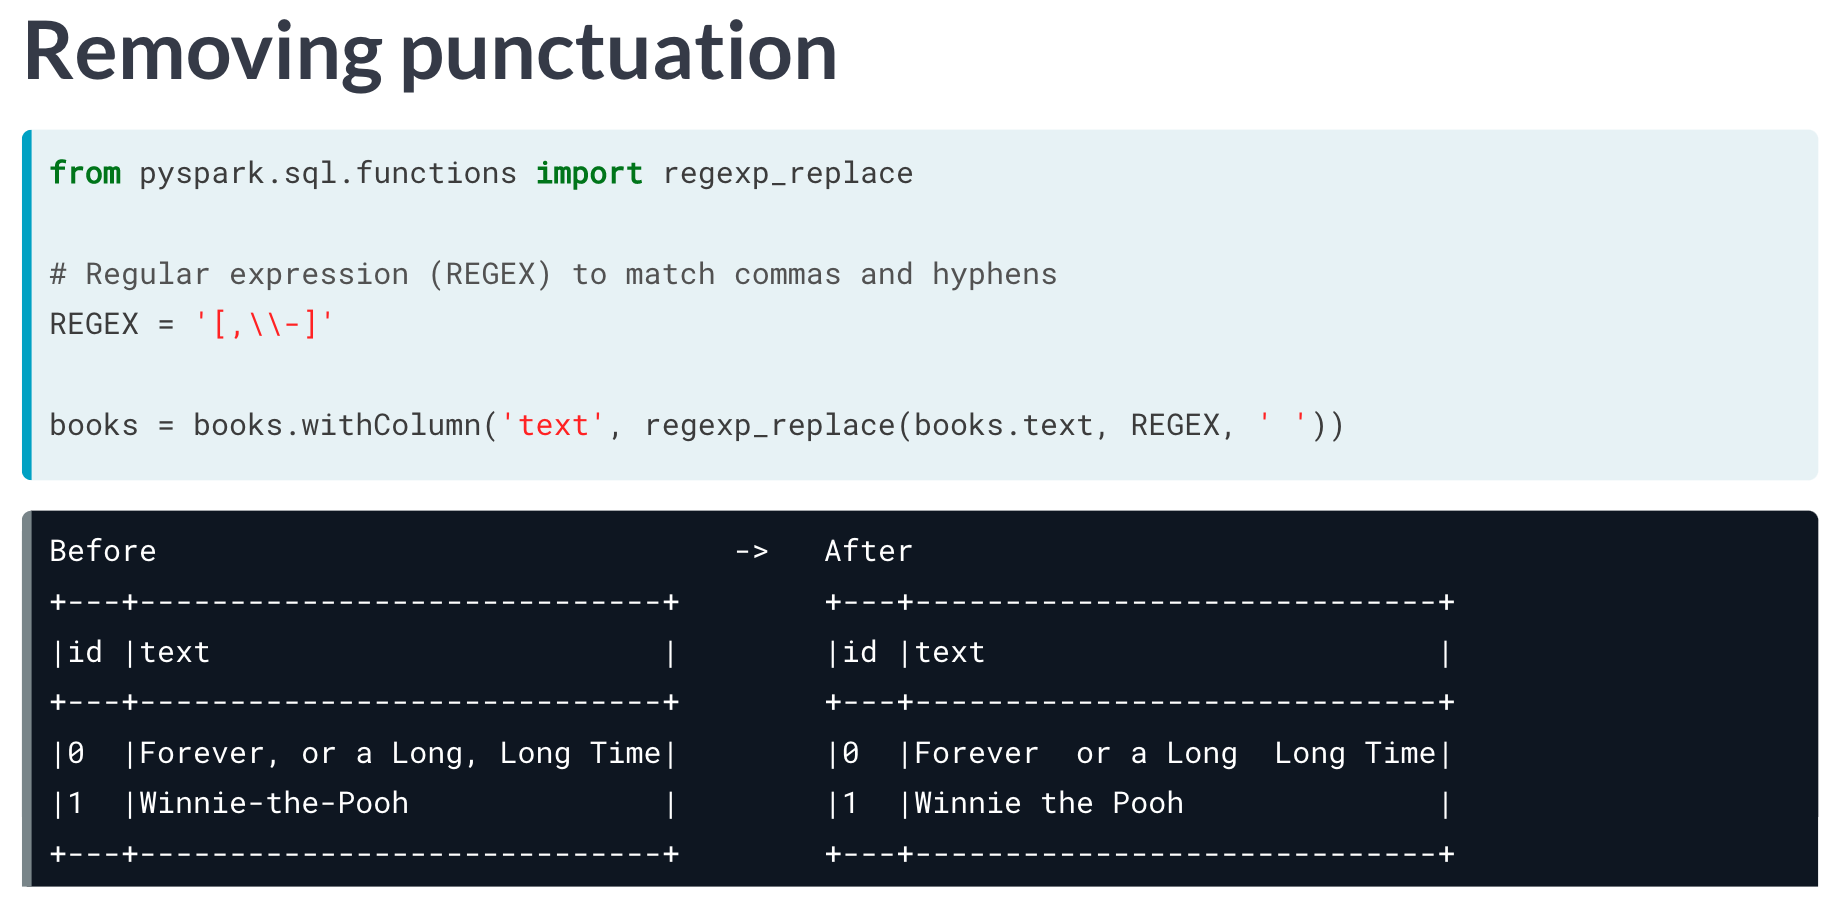

In [66]:
# Import the necessary functions
from pyspark.sql.functions import regexp_replace
from pyspark.ml.feature import Tokenizer

# Remove punctuation (REGEX provided) and numbers
wrangled = sms.withColumn('text', regexp_replace(sms.text, '[_():;,.!?\\-]', ' '))
wrangled = wrangled.withColumn('text', regexp_replace(wrangled.text, '[0-9]', ' '))

# Merge multiple spaces
wrangled = wrangled.withColumn('text', regexp_replace(wrangled.text, ' +', ' '))

# Split the text into words
wrangled = Tokenizer(inputCol='text', outputCol='words').transform(wrangled)

wrangled.show(4, truncate=False)

+---+----------------------------------+-----+------------------------------------------+
|id |text                              |label|words                                     |
+---+----------------------------------+-----+------------------------------------------+
|1  |Sorry I'll call later in meeting  |0    |[sorry, i'll, call, later, in, meeting]   |
|2  |Dont worry I guess he's busy      |0    |[dont, worry, i, guess, he's, busy]       |
|3  |Call FREEPHONE now                |1    |[call, freephone, now]                    |
|4  |Win a cash prize or a prize worth |1    |[win, a, cash, prize, or, a, prize, worth]|
+---+----------------------------------+-----+------------------------------------------+
only showing top 4 rows



In [67]:
from pyspark.ml.feature import StopWordsRemover, HashingTF, IDF

#set locale
locale = spark._jvm.java.util.Locale
locale.setDefault(locale.forLanguageTag("en-US"))

# Remove stop words.
wrangled = StopWordsRemover(inputCol='words', outputCol='terms')\
.transform(wrangled)
# Apply the hashing trick
wrangled = HashingTF(inputCol='terms', outputCol='hash', numFeatures=1024)\
      .transform(wrangled)
# Convert hashed symbols to TF-IDF
tf_idf = IDF(inputCol='hash', outputCol='features')\
      .fit(wrangled).transform(wrangled)   
tf_idf.select('terms', 'features').show(4, truncate=False)

+--------------------------------+----------------------------------------------------------------------------------------------------+
|terms                           |features                                                                                            |
+--------------------------------+----------------------------------------------------------------------------------------------------+
|[sorry, call, later, meeting]   |(1024,[138,344,378,1006],[2.2391682769656747,2.892706319430574,3.684405173719015,4.244020961654438])|
|[dont, worry, guess, busy]      |(1024,[53,233,329,858],[4.618714411095849,3.557143394108088,4.618714411095849,4.937168142214383])   |
|[call, freephone]               |(1024,[138,396],[2.2391682769656747,3.3843005812686773])                                            |
|[win, cash, prize, prize, worth]|(1024,[31,69,387,428],[3.7897656893768414,7.284881949239966,4.4671645129686475,3.898659777615979])  |
+--------------------------------+--------------

In [68]:
# Split the data into training and testing sets
sms_train, sms_test = tf_idf.randomSplit([0.8,0.2],seed=13)

# Fit a Logistic Regression model to the training data
logistic = LogisticRegression(regParam=0.2).fit(sms_train)

# Make predictions on the testing data
prediction = logistic.transform(sms_test)

# Create a confusion matrix, comparing predictions to known labels
prediction.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   47|
|    0|       0.0|  987|
|    1|       1.0|  124|
|    0|       1.0|    3|
+-----+----------+-----+



In [69]:
#TP + TN / TP+TN+FP+FN
TN = prediction.filter('prediction = 0 AND label = prediction').count()
TP = prediction.filter('prediction = 1 AND label = prediction').count()
FN = prediction.filter('prediction = 0 AND label = 1').count()
FP = prediction.filter('prediction = 1 AND label = 0').count()
accuracy = (TN+TP)/(TN+TP+FN+FP)
print(accuracy)

0.9569336778639104


In [70]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Calculate precision and recall
precision = TP/(TP+FP)
recall = TP/(TP+FN)
print('precision = {:.2f}\nrecall    = {:.2f}'.format(precision, recall))

# Find weighted precision
multi_evaluator = MulticlassClassificationEvaluator()
weighted_precision = multi_evaluator.evaluate(prediction, {multi_evaluator.metricName: "weightedPrecision"})

# Find AUC
binary_evaluator = BinaryClassificationEvaluator()
auc = binary_evaluator.evaluate(prediction, {binary_evaluator.metricName: "areaUnderROC"})

precision = 0.98
recall    = 0.73


In [71]:
auc

0.9852088132789826

***ONE HOT ENCODING***<BR>
***INDEXED TO NUMERICAL VALUES IS NOT ENOUGHT TO REGRESSION***
    
    Sparse representation is to avoid multiple columns

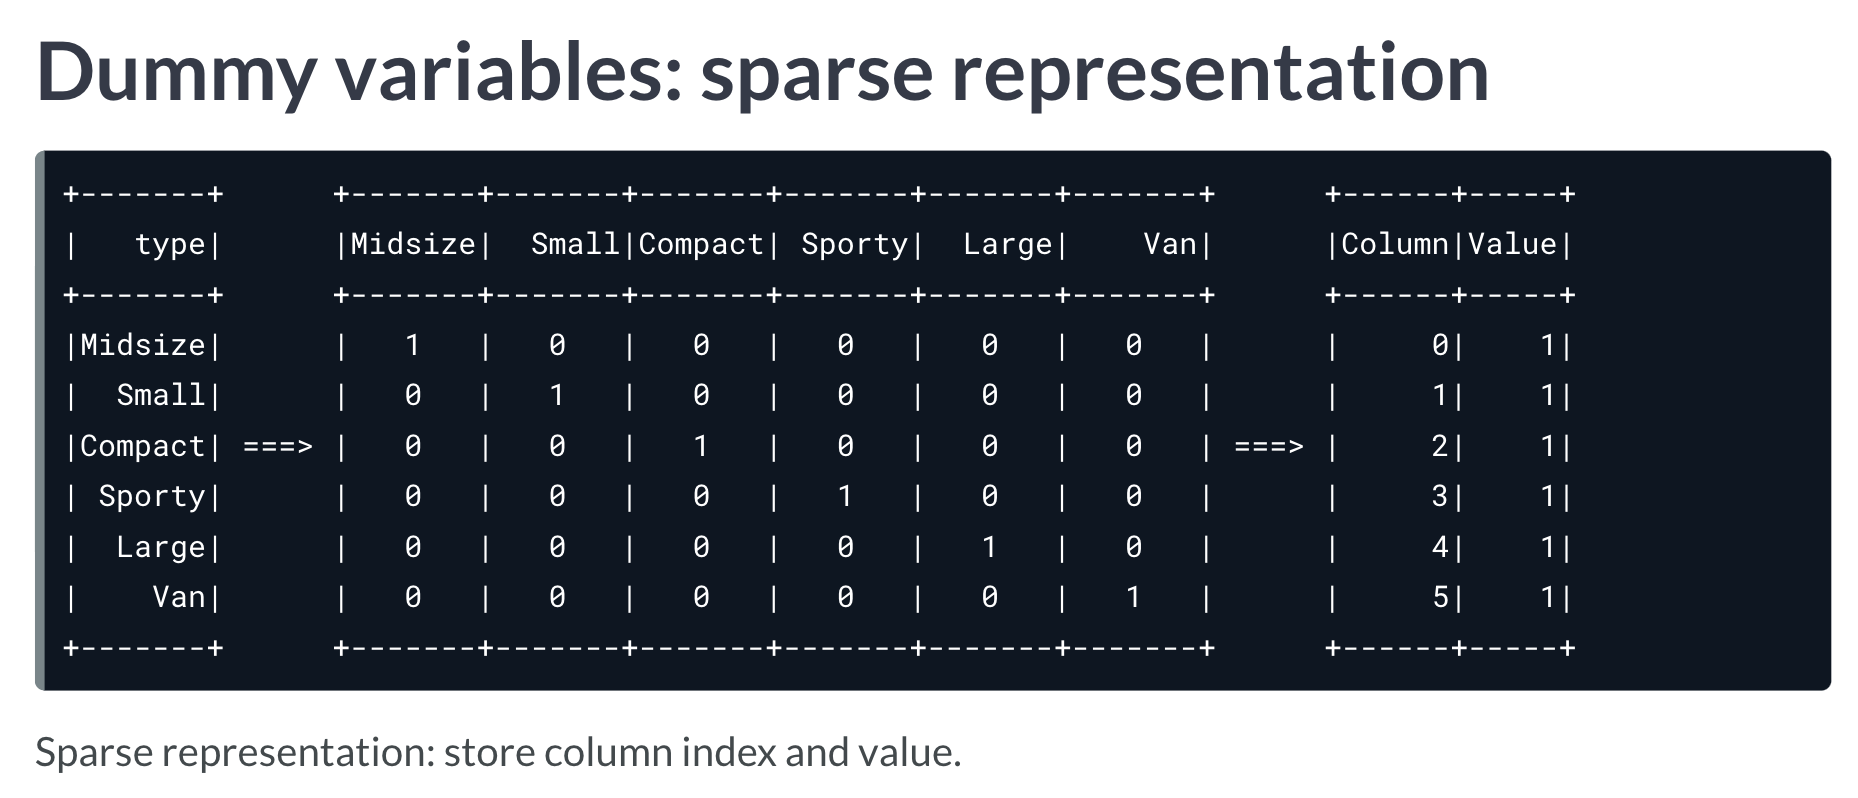

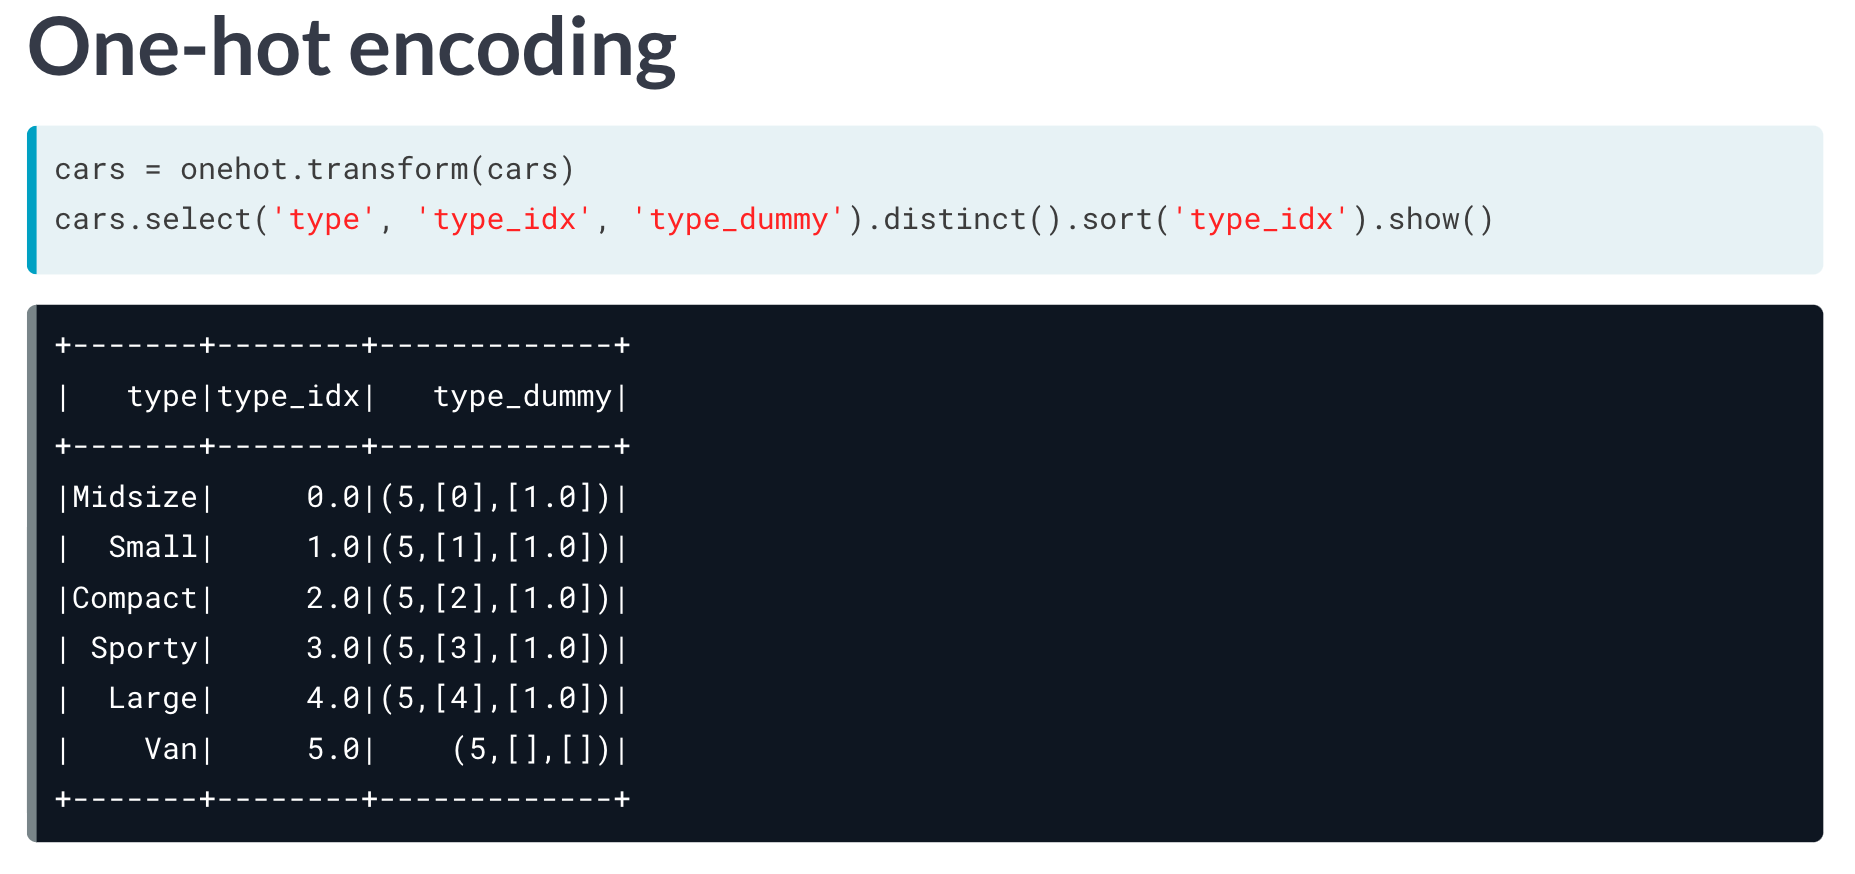

SparseVector(size_vector,position_non_zero,values of each position) so<br>

position 0 has 1.0<br>
position 5 has 7<br>
so<br>
[0,5]<br>

values of each position:<br>
position 0 has a value of 1 and<br>
position 5 has a value of 7 so<br>
[1,7]<br>

SparseVector(8,[0,5],[1,7])

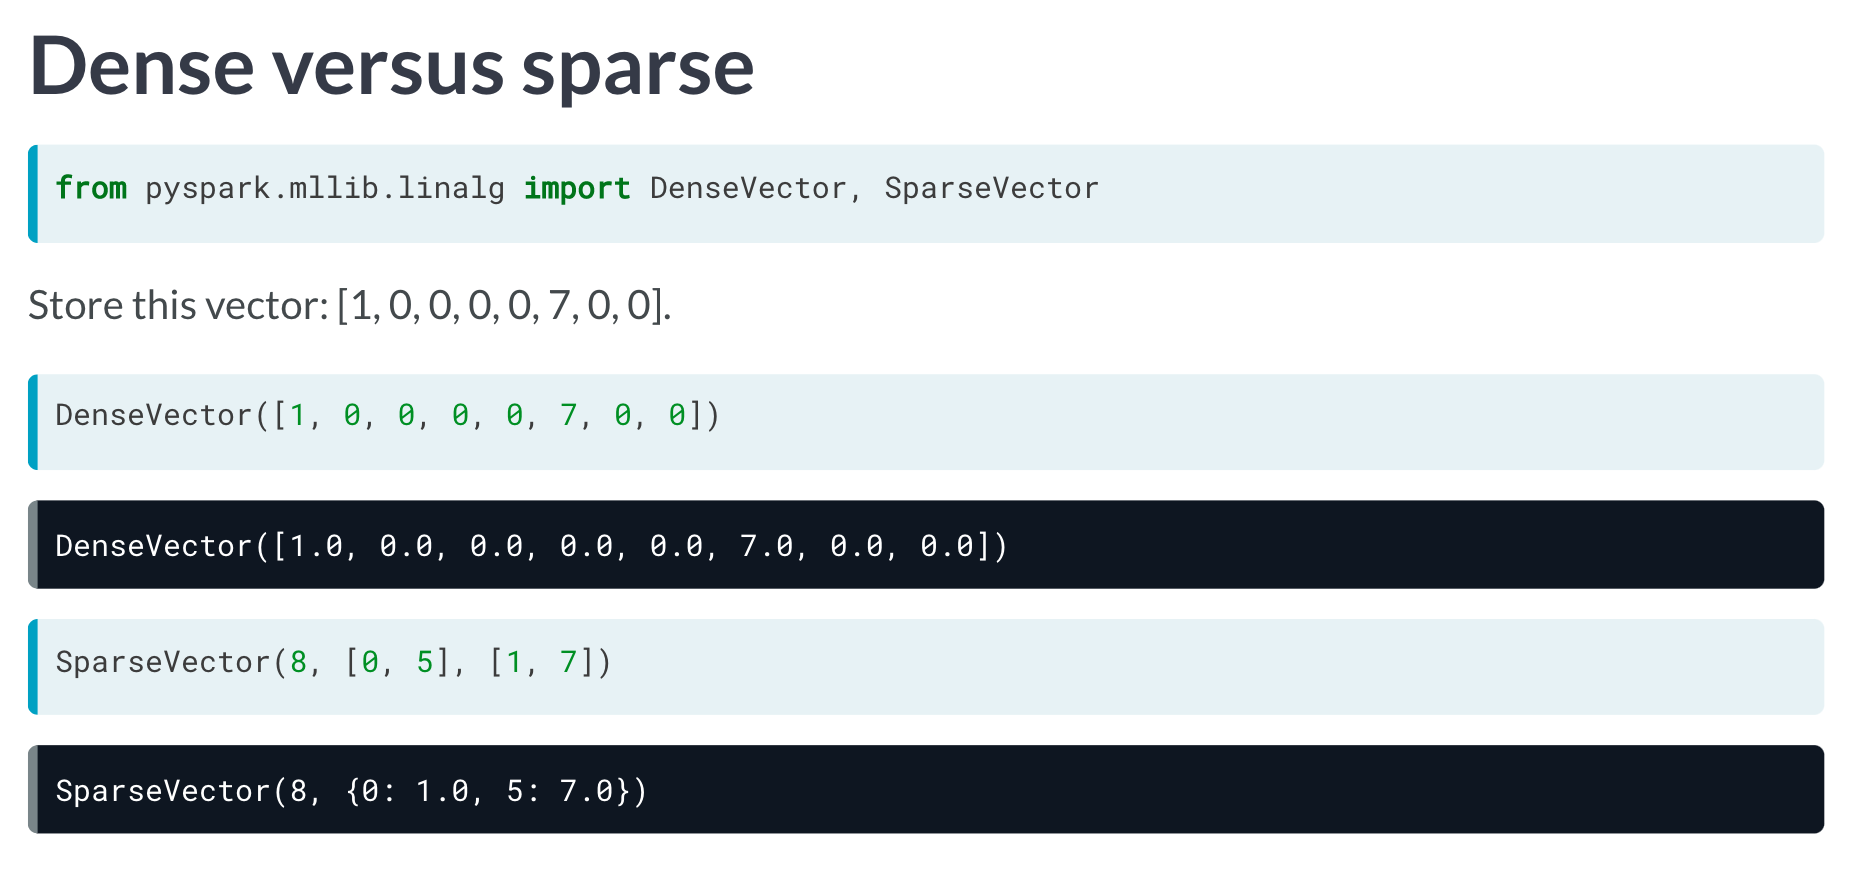

In [85]:
flights_indexed.show()

+---+---+---+-------+------+---+----+------+--------+-----+-----------+-------+
|mon|dom|dow|carrier|flight|org|mile|depart|duration|delay|carrier_idx|org_idx|
+---+---+---+-------+------+---+----+------+--------+-----+-----------+-------+
| 11| 20|  6|     US|    19|JFK|2153|  9.48|     351| null|        6.0|    2.0|
|  0| 22|  2|     UA|  1107|ORD| 316| 16.33|      82|   30|        0.0|    0.0|
|  2| 20|  4|     UA|   226|SFO| 337|  6.17|      82|   -8|        0.0|    1.0|
|  9| 13|  1|     AA|   419|ORD|1236| 10.33|     195|   -5|        1.0|    0.0|
|  4|  2|  5|     AA|   325|ORD| 258|  8.92|      65| null|        1.0|    0.0|
|  5|  2|  1|     UA|   704|SFO| 550|  7.98|     102|    2|        0.0|    1.0|
|  7|  2|  6|     AA|   380|ORD| 733| 10.83|     135|   54|        1.0|    0.0|
|  1| 16|  6|     UA|  1477|ORD|1440|   8.0|     232|   -7|        0.0|    0.0|
|  1| 22|  5|     UA|   620|SJC|1829|  7.98|     250|  -13|        0.0|    4.0|
| 11|  8|  1|     OO|  5590|SFO| 158|  7

In [88]:
# Import the one hot encoder class
from pyspark.ml.feature import OneHotEncoderEstimator

# Create an instance of the one hot encoder
onehot = OneHotEncoderEstimator(inputCols=['org_idx'], outputCols=['org_dummy'])

# Apply the one hot encoder to the flights data
onehot = onehot.fit(flights_indexed)
flights_onehot = onehot.transform(flights_indexed)

# Check the results
flights_onehot.select('org', 'org_idx', 'org_dummy').distinct().sort('org_idx').show()

+---+-------+-------------+
|org|org_idx|    org_dummy|
+---+-------+-------------+
|ORD|    0.0|(7,[0],[1.0])|
|SFO|    1.0|(7,[1],[1.0])|
|JFK|    2.0|(7,[2],[1.0])|
|LGA|    3.0|(7,[3],[1.0])|
|SJC|    4.0|(7,[4],[1.0])|
|SMF|    5.0|(7,[5],[1.0])|
|TUS|    6.0|(7,[6],[1.0])|
|OGG|    7.0|    (7,[],[])|
+---+-------+-------------+



In [115]:
from pyspark.ml.feature import VectorAssembler

# Create an assembler object
assembler = VectorAssembler(inputCols=[
    'mon','dom','dow','depart','duration','org_dummy'
], outputCol='features')

# Consolidate predictor columns
flights_assembled = assembler.transform(flights_onehot)

flights_assembled = flights_assembled.dropna()
flights_assembled.show(5)

+---+---+---+-------+------+---+----+------+--------+-----+-----------+-------+-------------+--------------------+
|mon|dom|dow|carrier|flight|org|mile|depart|duration|delay|carrier_idx|org_idx|    org_dummy|            features|
+---+---+---+-------+------+---+----+------+--------+-----+-----------+-------+-------------+--------------------+
|  0| 22|  2|     UA|  1107|ORD| 316| 16.33|      82|   30|        0.0|    0.0|(7,[0],[1.0])|(12,[1,2,3,4,5],[...|
|  2| 20|  4|     UA|   226|SFO| 337|  6.17|      82|   -8|        0.0|    1.0|(7,[1],[1.0])|(12,[0,1,2,3,4,6]...|
|  9| 13|  1|     AA|   419|ORD|1236| 10.33|     195|   -5|        1.0|    0.0|(7,[0],[1.0])|(12,[0,1,2,3,4,5]...|
|  5|  2|  1|     UA|   704|SFO| 550|  7.98|     102|    2|        0.0|    1.0|(7,[1],[1.0])|(12,[0,1,2,3,4,6]...|
|  7|  2|  6|     AA|   380|ORD| 733| 10.83|     135|   54|        1.0|    0.0|(7,[0],[1.0])|(12,[0,1,2,3,4,5]...|
+---+---+---+-------+------+---+----+------+--------+-----+-----------+-------+-

In [116]:
# Split into training and testing sets in a 80:20 ratio
flights_train, flights_test = flights_assembled.randomSplit([0.8,0.2],seed=17)

each point difference with the line is a residual.<br>
best model would try to make the these residuals are small as possible<br>
best model is found minimizing the Mean square error. MSE<br>


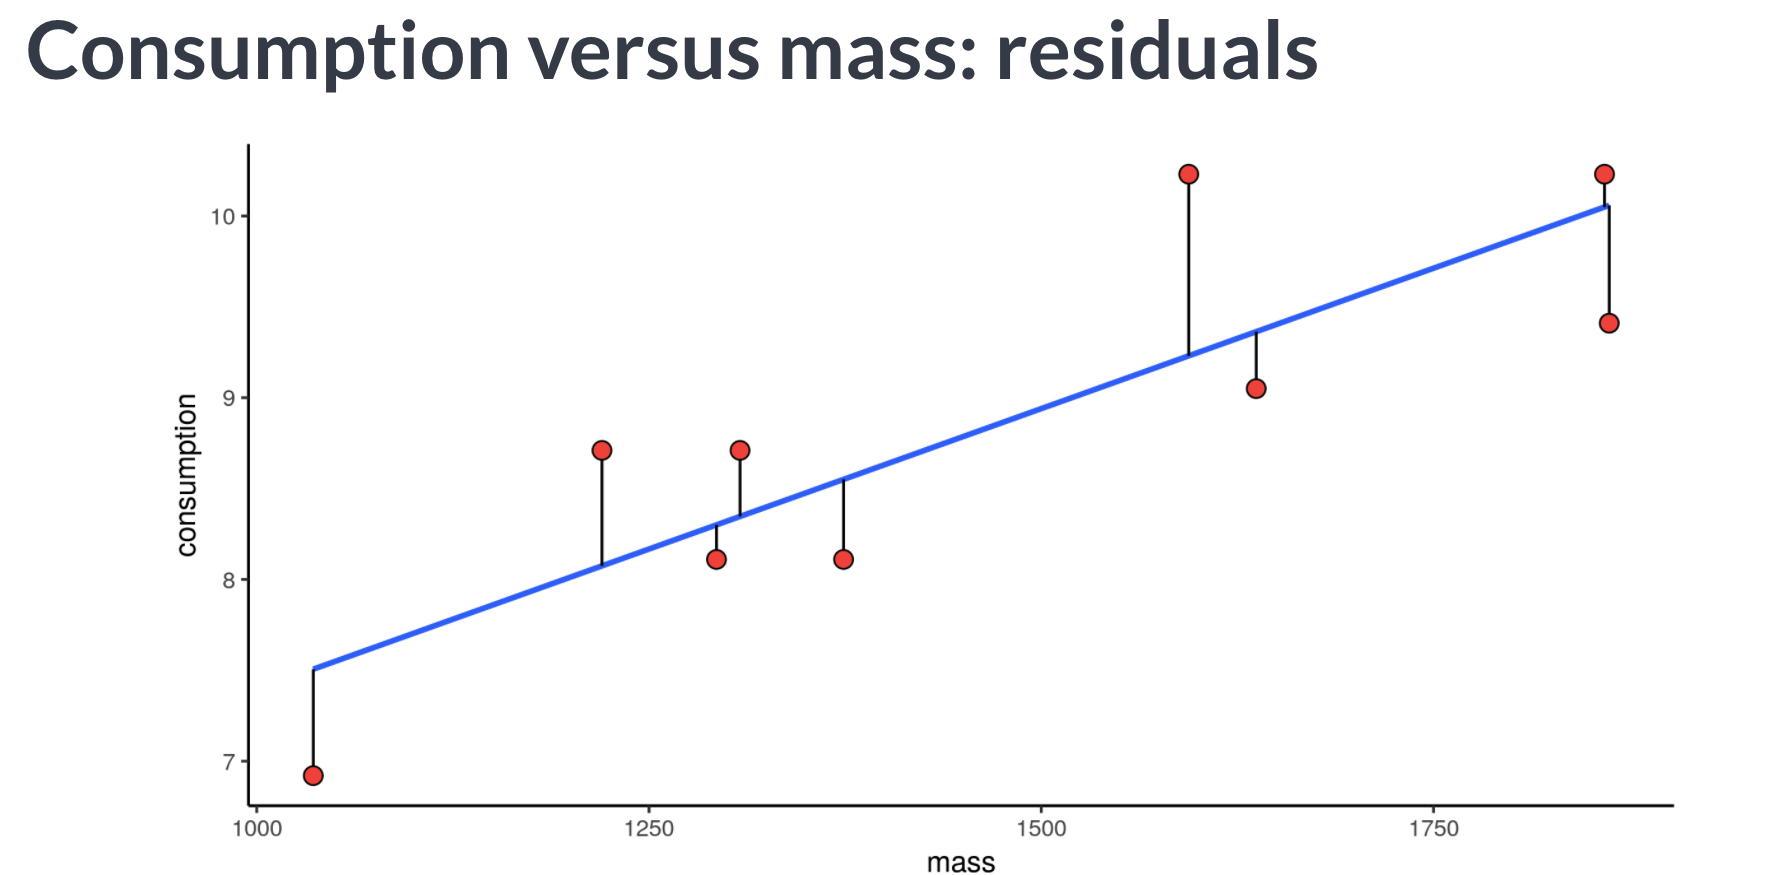

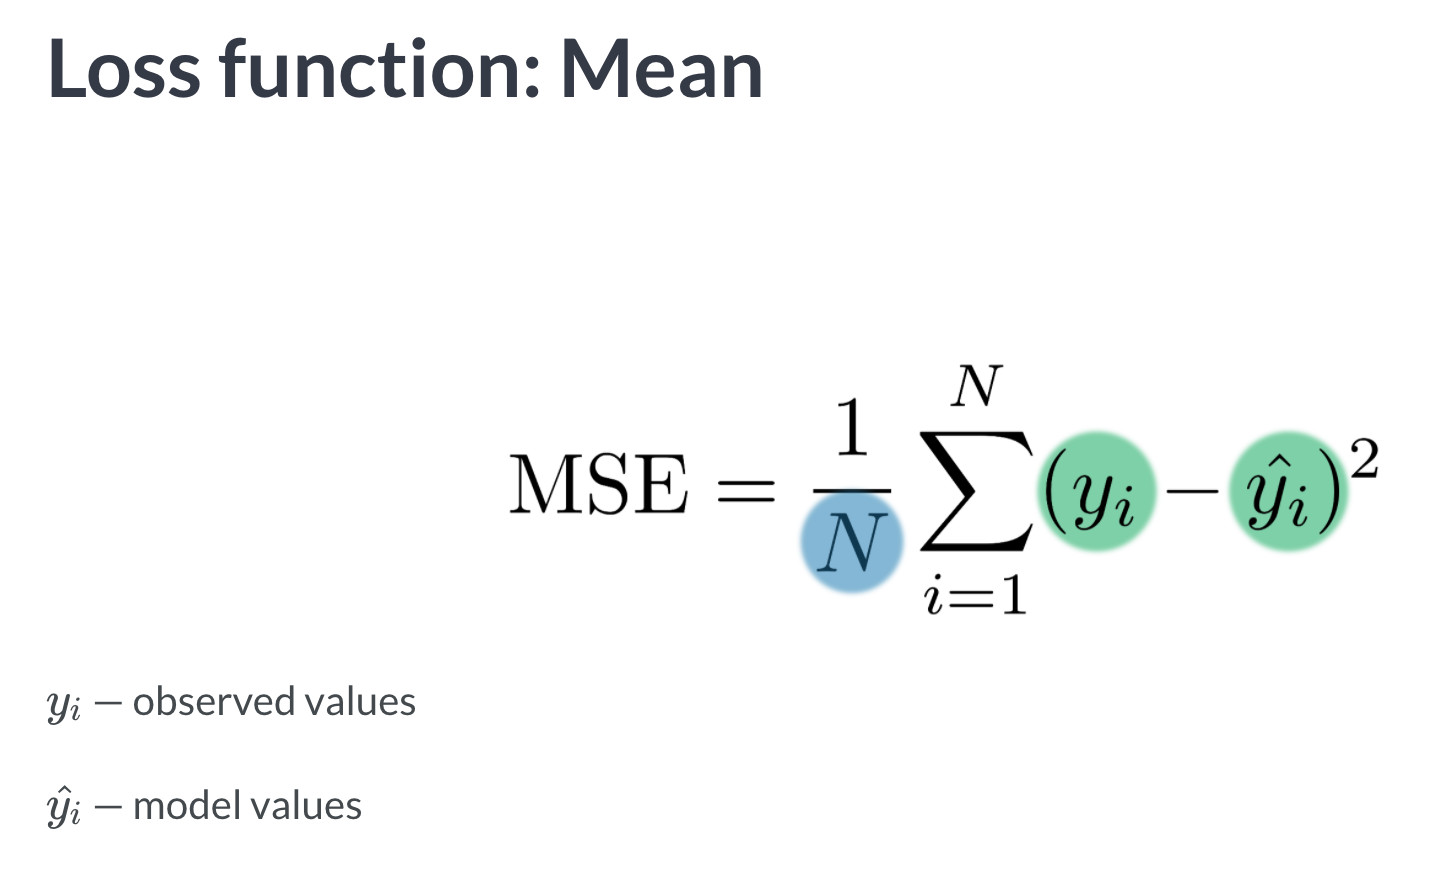

***ROOT MEAN SQUARE ERROR IS OFTEN USED FOR REGRESSION MODELS***<br>
A smaller RMSE always indicates better predictions.

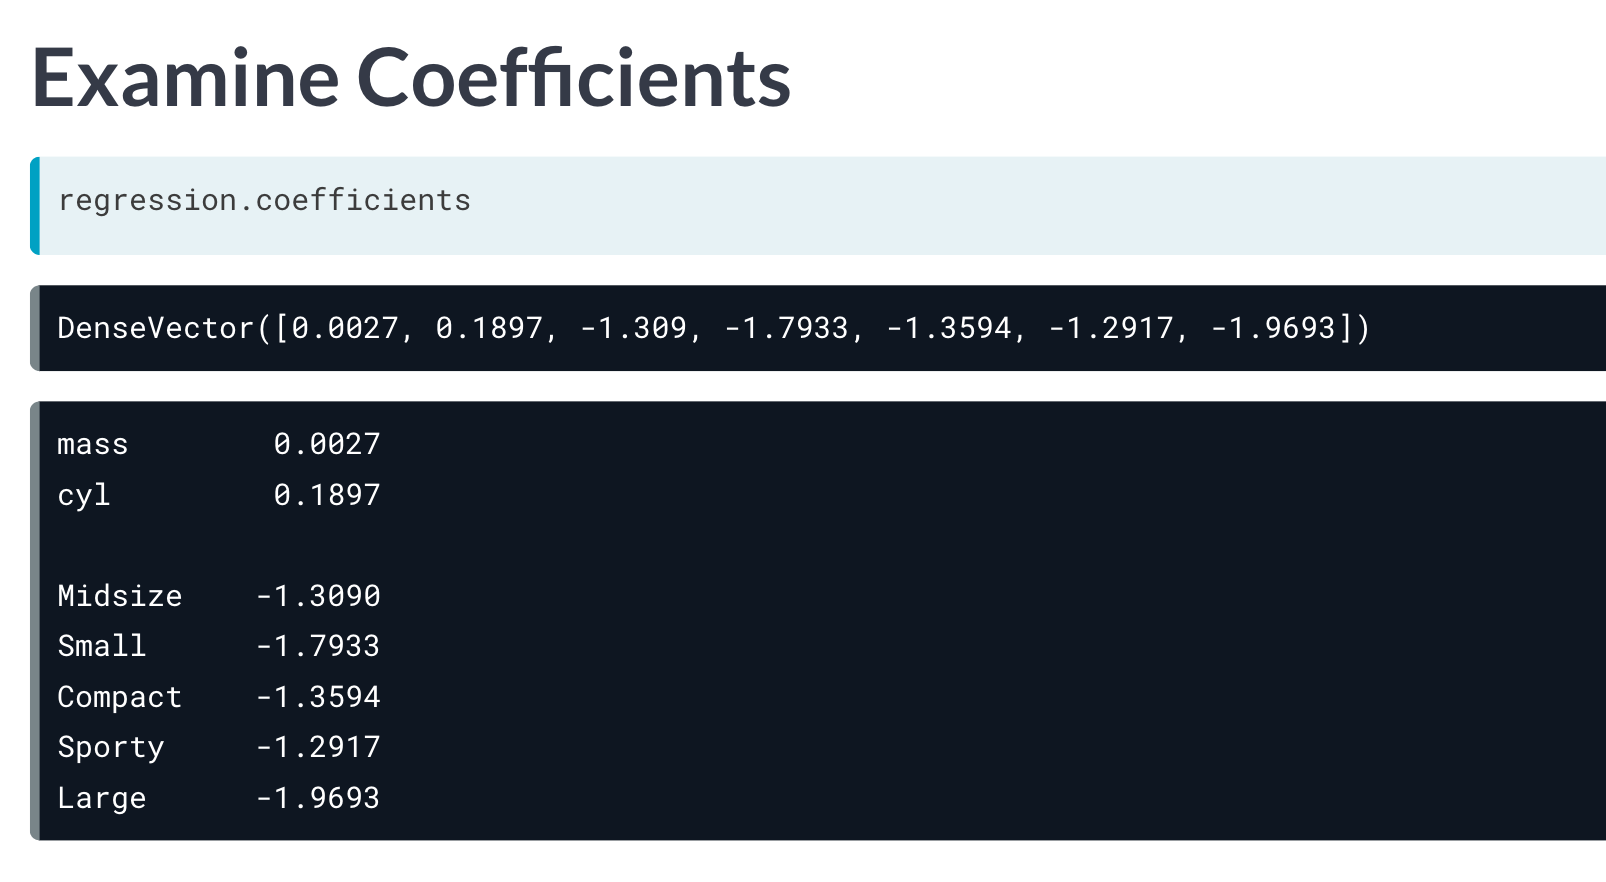

When mass increase by one unit, fuel consumption increase 0.0027 taking into account mass and cyl.

midsize, small, compact,sporty and large are coefficient for mass.

for a especific mass and cyl large type fuel vehicules are most fuel efficients

In [117]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Create a regression object and train on training data
regression = LinearRegression(labelCol="duration").fit(flights_train)

# Create predictions for the testing data and take a look at the predictions
predictions = regression.transform(flights_test)
predictions.select('duration', 'prediction').show(10, False)

# Calculate the RMSE
RegressionEvaluator(labelCol="duration").evaluate(predictions)

+--------+------------------+
|duration|prediction        |
+--------+------------------+
|135     |135.0             |
|80      |79.99999999999996 |
|130     |130.0             |
|180     |180.00000000000003|
|123     |122.99999999999999|
|270     |270.0000000000001 |
|155     |155.0             |
|170     |170.00000000000003|
|301     |301.0000000000002 |
|174     |174.0             |
+--------+------------------+
only showing top 10 rows



5.2451260729303397e-14

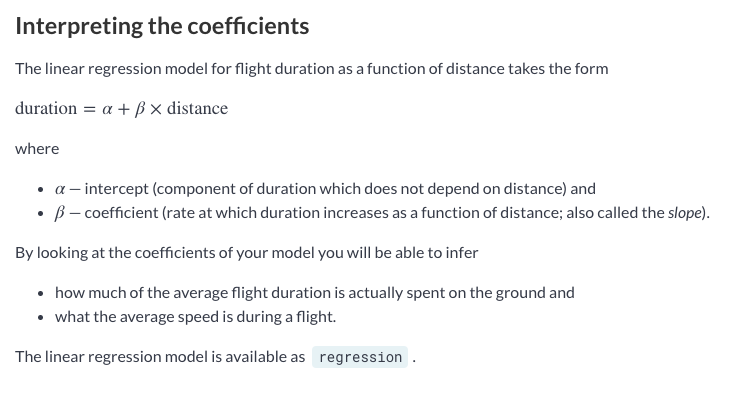

In [118]:
# Intercept (average minutes on ground)
inter = regression.intercept
print(inter)

# Coefficients
coefs = regression.coefficients
print(coefs)

# Average minutes per km
minutes_per_km = coefs.values[0]
print(minutes_per_km)

# Average speed in km per hour
avg_speed = 60 / minutes_per_km
print(avg_speed)

9.014270752873924e-14
[-2.7398332567407285e-15,2.9354051559954996e-17,-5.4869734366305545e-15,-7.217422098342609e-16,1.0000000000000004,-1.216245674093079e-13,-1.2344075160479752e-13,-1.475862422881111e-13,-1.2476486309419441e-13,-1.1360518433648864e-13,-1.0818547869212677e-13,-1.1324249149153304e-13]
-2.7398332567407285e-15
-2.189914289578894e+16


In [119]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Create a regression object and train on training data
regression = LinearRegression(labelCol="duration").fit(flights_assembled)

# Create predictions for the testing data
predictions = regression.transform(flights_test)

# Calculate the RMSE on testing data
RegressionEvaluator(labelCol="duration").evaluate(predictions)

2.839854842320623e-14

In [120]:
flights_train.show(5)

+---+---+---+-------+------+---+----+------+--------+-----+-----------+-------+-------------+--------------------+
|mon|dom|dow|carrier|flight|org|mile|depart|duration|delay|carrier_idx|org_idx|    org_dummy|            features|
+---+---+---+-------+------+---+----+------+--------+-----+-----------+-------+-------------+--------------------+
|  0|  1|  2|     AA|     3|JFK|2475|  12.0|     370|   11|        1.0|    2.0|(7,[2],[1.0])|(12,[1,2,3,4,7],[...|
|  0|  1|  2|     AA|    59|JFK|2586|   7.0|     385|  -16|        1.0|    2.0|(7,[2],[1.0])|(12,[1,2,3,4,7],[...|
|  0|  1|  2|     AA|    73|ORD|4243|  9.08|     560|   39|        1.0|    0.0|(7,[0],[1.0])|(12,[1,2,3,4,5],[...|
|  0|  1|  2|     AA|   150|SFO|2704| 23.42|     325|   22|        1.0|    1.0|(7,[1],[1.0])|(12,[1,2,3,4,6],[...|
|  0|  1|  2|     AA|   181|JFK|2475|  17.0|     379|  -10|        1.0|    2.0|(7,[2],[1.0])|(12,[1,2,3,4,7],[...|
+---+---+---+-------+------+---+----+------+--------+-----+-----------+-------+-

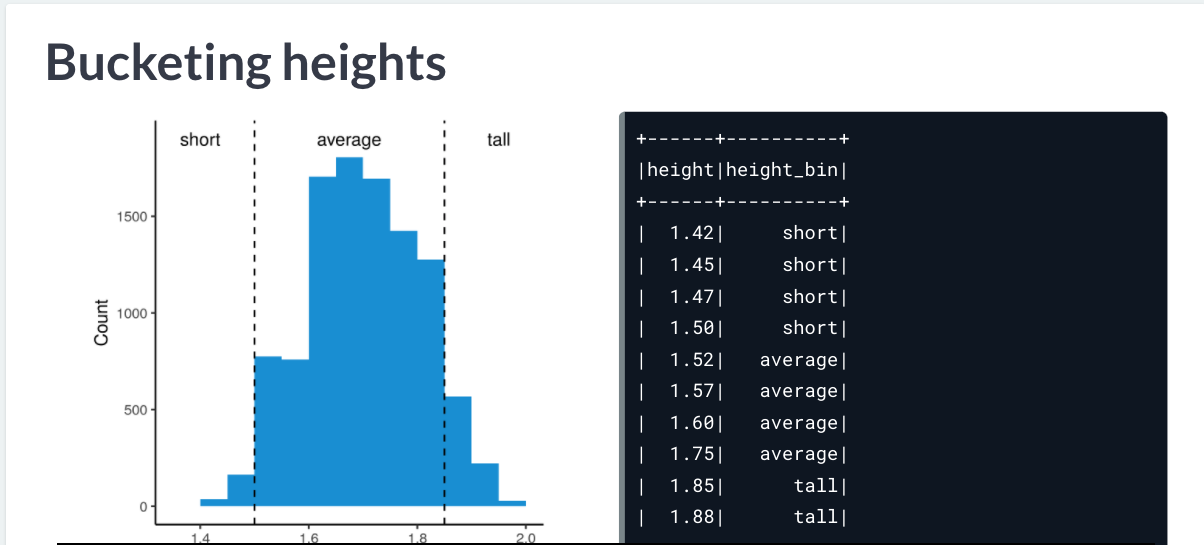

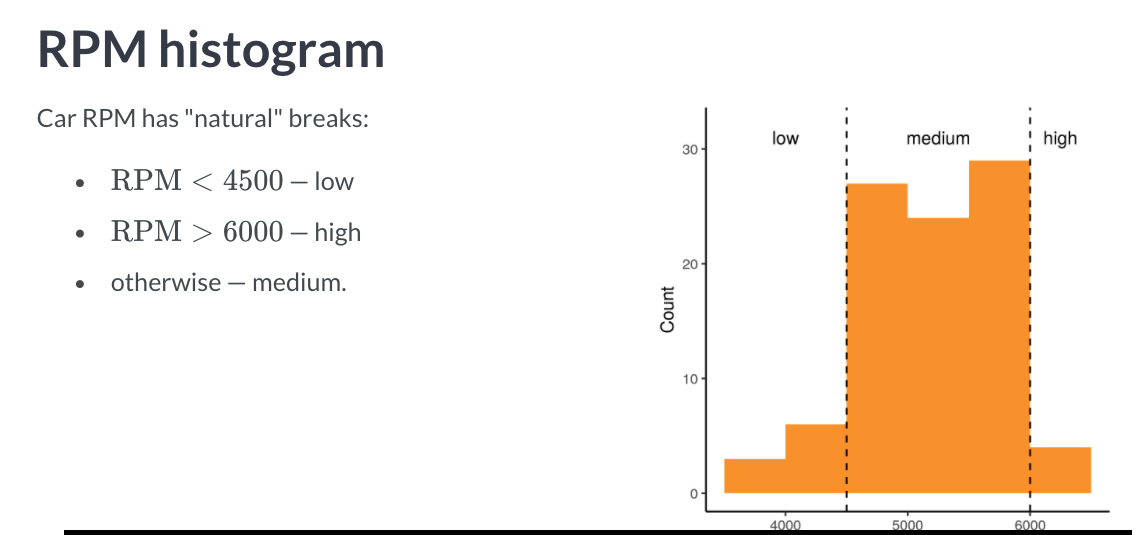

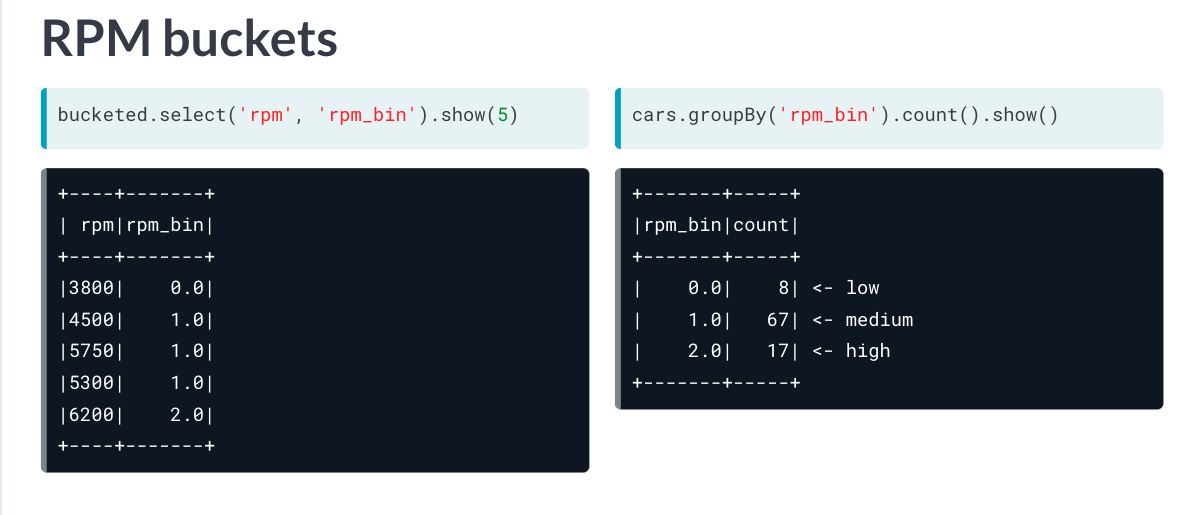

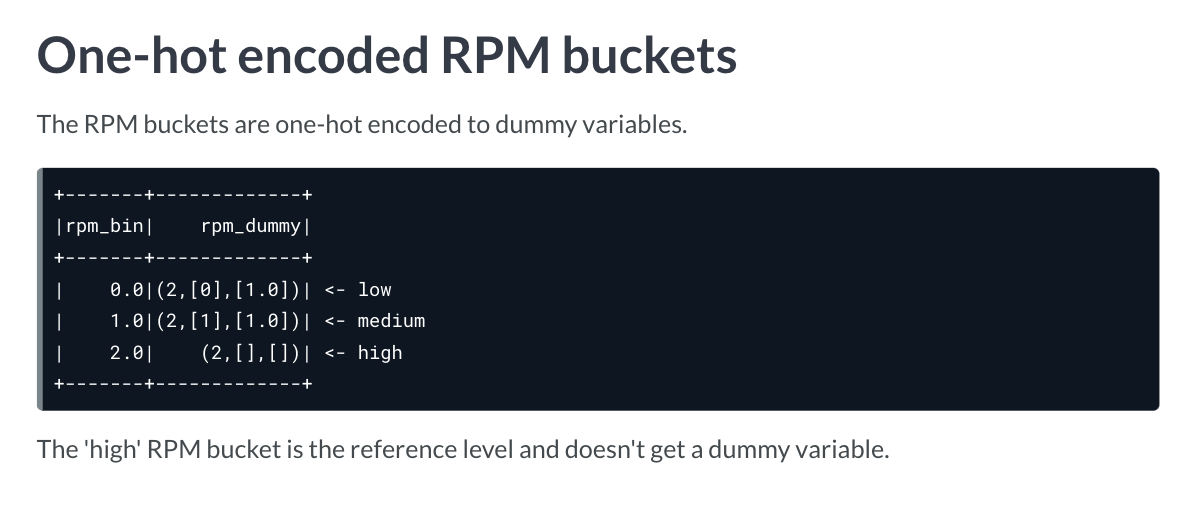

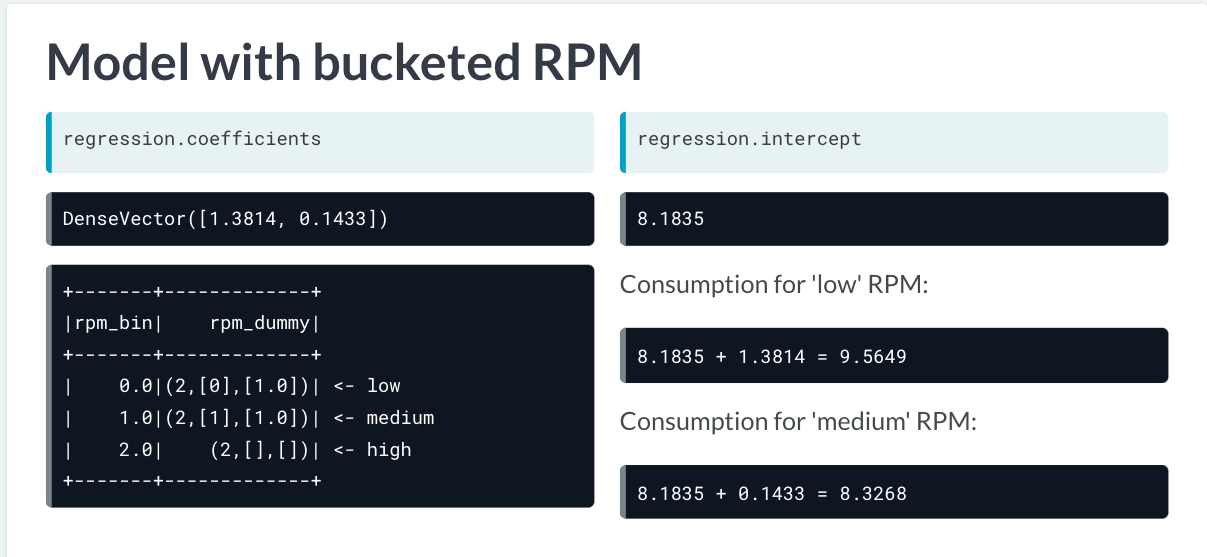

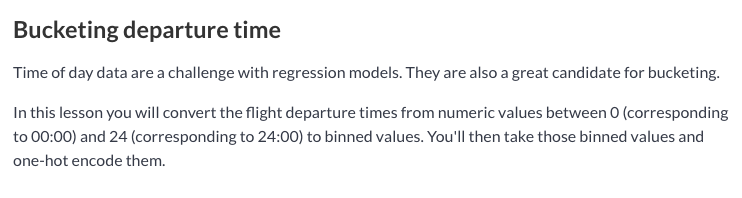

In [122]:
from pyspark.ml.feature import Bucketizer, OneHotEncoderEstimator

# Create buckets at 3 hour intervals through the day
buckets = Bucketizer(splits=[0,3,6,9,12,15,18,21,24], inputCol="depart", outputCol="depart_bucket")

# Bucket the departure times
bucketed = buckets.transform(flights)
bucketed.select('depart','depart_bucket').show(5)

# Create a one-hot encoder
onehot = OneHotEncoderEstimator(inputCols=['depart_bucket'], outputCols=['depart_dummy'])

# One-hot encode the bucketed departure times
flights_onehot = onehot.fit(bucketed).transform(bucketed)
flights_onehot.select('depart','depart_bucket','depart_dummy').show(5)

+------+-------------+
|depart|depart_bucket|
+------+-------------+
|  9.48|          3.0|
| 16.33|          5.0|
|  6.17|          2.0|
| 10.33|          3.0|
|  8.92|          2.0|
+------+-------------+
only showing top 5 rows

+------+-------------+-------------+
|depart|depart_bucket| depart_dummy|
+------+-------------+-------------+
|  9.48|          3.0|(7,[3],[1.0])|
| 16.33|          5.0|(7,[5],[1.0])|
|  6.17|          2.0|(7,[2],[1.0])|
| 10.33|          3.0|(7,[3],[1.0])|
|  8.92|          2.0|(7,[2],[1.0])|
+------+-------------+-------------+
only showing top 5 rows



In [123]:
# Find the RMSE on testing data
from pyspark.ml.evaluation import RegressionEvaluator
RegressionEvaluator(labelCol="duration").evaluate(predictions)

# Average minutes on ground at OGG for flights departing between 21:00 and 24:00
avg_eve_ogg = regression.intercept
print(avg_eve_ogg)

# Average minutes on ground at OGG for flights departing between 00:00 and 03:00
avg_night_ogg = regression.intercept + regression.coefficients[8]
print(avg_night_ogg)

# Average minutes on ground at JFK for flights departing between 00:00 and 03:00
avg_night_jfk = regression.intercept + regression.coefficients[8] + regression.coefficients[3]
print(avg_night_jfk)

-4.937645826715911e-15
6.160699179447528e-14
6.08852036100739e-14


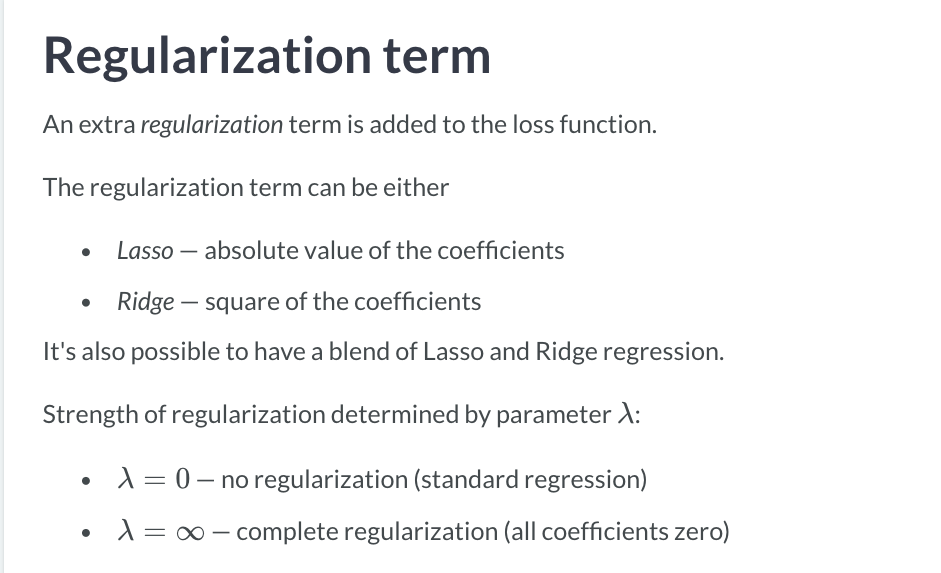

***LASSO REGRESSION CAN BE USED TO SELECT THE BEST PREDICTORS***

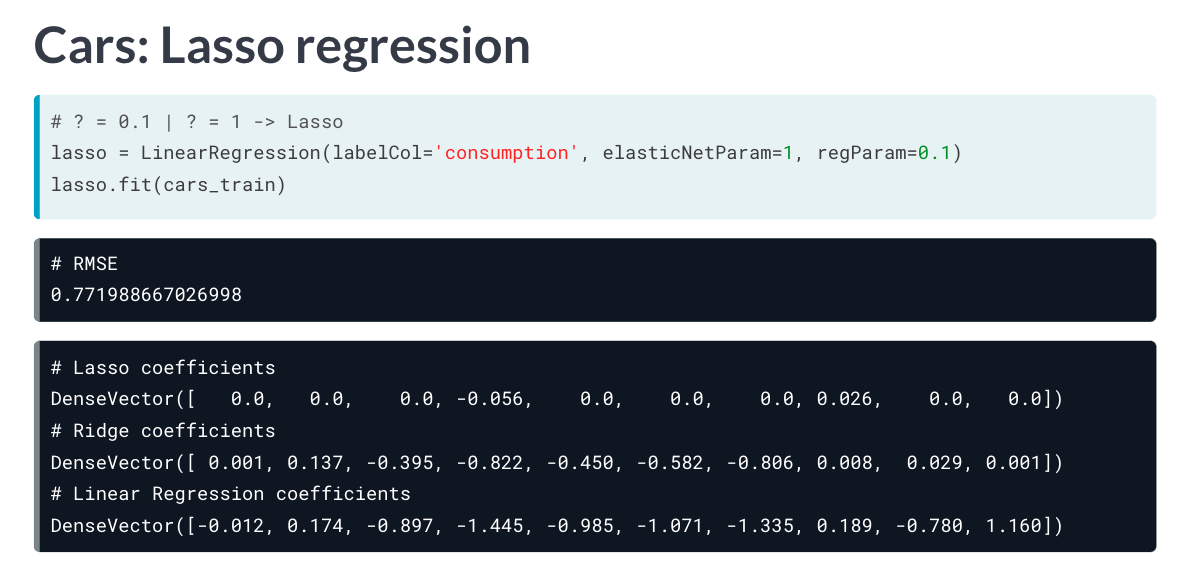

In the above model we identified that if we used the features with values -0.056 and 0.026 are good predictors

In [124]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Fit linear regression model to training data
regression = LinearRegression(labelCol="duration").fit(flights_train)

# Make predictions on testing data
predictions = regression.transform(flights_test)

# Calculate the RMSE on testing data
rmse = RegressionEvaluator(labelCol="duration").evaluate(predictions)
print("The test RMSE is", rmse)

# Look at the model coefficients
coeffs = regression.coefficients
print(coeffs)

The test RMSE is 5.2451260729303397e-14
[-2.7398332567407285e-15,2.9354051559954996e-17,-5.4869734366305545e-15,-7.217422098342609e-16,1.0000000000000004,-1.216245674093079e-13,-1.2344075160479752e-13,-1.475862422881111e-13,-1.2476486309419441e-13,-1.1360518433648864e-13,-1.0818547869212677e-13,-1.1324249149153304e-13]


In [125]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Fit Lasso model (α = 1) to training data
regression = LinearRegression(labelCol='duration', regParam=1, elasticNetParam=1).fit(flights_train)

# Calculate the RMSE on testing data
rmse = RegressionEvaluator(labelCol="duration").evaluate(regression.transform(flights_test))
print("The test RMSE is", rmse)


# Look at the model coefficients
coeffs = regression.coefficients
print(coeffs)

# Number of zero coefficients
zero_coeff = sum([beta==0 for beta in regression.coefficients])
print("Number of coefficients equal to 0:", zero_coeff)

The test RMSE is 1.0045246507191645
[0.0,0.0,0.0,0.0,0.9885738159729598,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
Number of coefficients equal to 0: 11


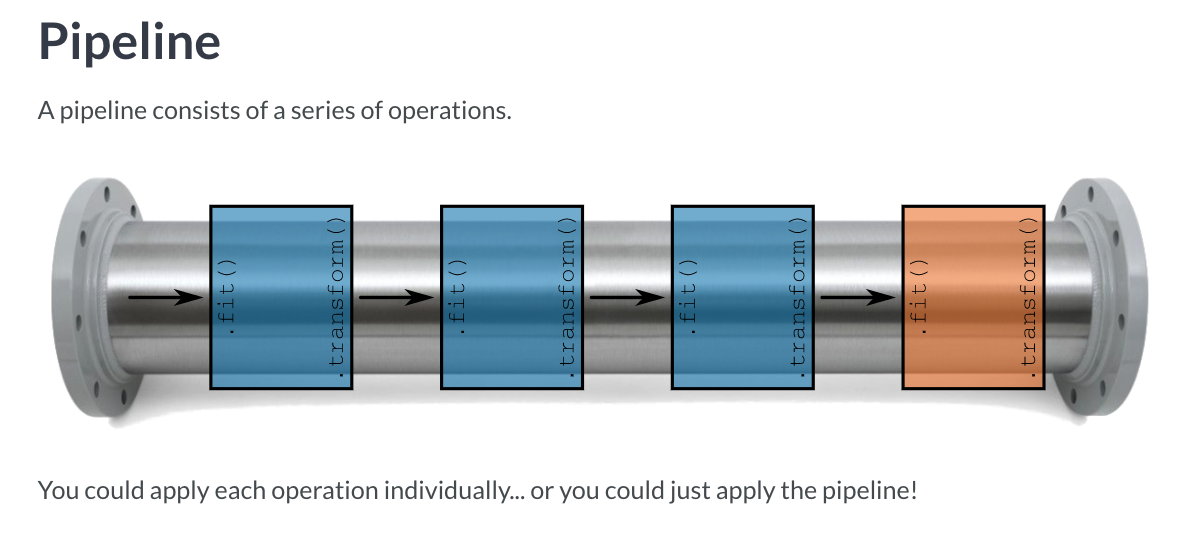

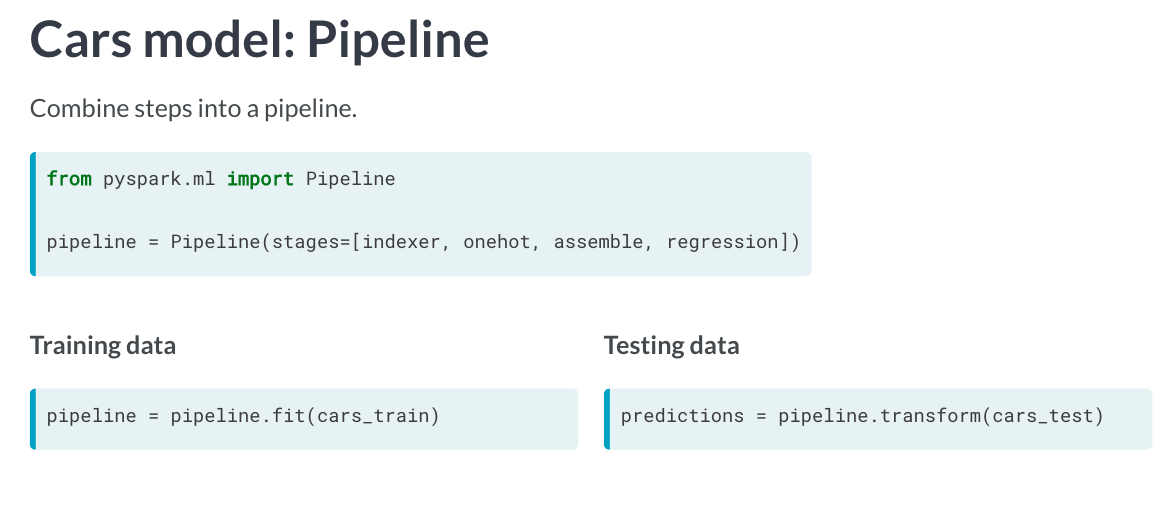